In [1]:
!pip install kmodes==0.12.2


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# from kmodes.kprototypes import KPrototypes

# TEM QUE VER

- [x] Distribuição dos clusters muito desigual

- [x] Cluster final vai estar muito grande por falta de caracterização (todos são muito parecidos, independente das variáveis escolhidas)

- [ ] Separar entre perguntas (hipóteses) gerais e específicas

- [ ] Limpar o código

- [x] Normalizar população também?

# Importação dos dados

In [3]:
# Carregando os datasets municipios gerais
original_municipios_df = pd.read_csv('./Data/municipios.csv')
municipios_df = original_municipios_df.copy()
original_municipios_df

,codigo_ibge,nome,latitude,longitude,codigo_uf
0,5200050,Abadia de Goiás,-16.75730,-49.4412,52
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,31
2,5200100,Abadiânia,-16.19700,-48.7057,52
3,3100203,Abaeté,-19.15510,-45.4444,31
4,1500107,Abaetetuba,-1.72183,-48.8788,15
...,...,...,...,...,...
5565,2933604,Xique-Xique,-10.82300,-42.7245,29
5566,2517407,Zabelê,-8.07901,-37.1057,25
5567,3557154,Zacarias,-21.05060,-50.0552,35
5568,2114007,Zé Doca,-3.27014,-45.6553,21


In [4]:
# Dataset de municipios apenas do semiárido
original_municipios_semiarido_df = pd.read_csv('./Data/municipios_semiarido.csv')
municipios_semiarido_df = original_municipios_semiarido_df.copy()
original_municipios_semiarido_df

,Cod IBGE,UF,Município,População Estimada - 2017
0,2700102,AL,ÁGUA BRANCA,20467
1,2700300,AL,ARAPIRACA,234185
2,2700706,AL,BATALHA,18757
3,2700904,AL,BELO MONTE,6797
4,2701209,AL,CACIMBINHAS,10897
...,...,...,...,...
1257,2806008,SE,RIBEIRÓPOLIS,18641
1258,2807006,SE,SÃO MIGUEL DO ALEIXO,3943
1259,2807105,SE,SIMÃO DIAS,40838
1260,2807303,SE,TELHA,3221


In [5]:
# Dataset de dados administrativos
original_administrativos_df = pd.read_csv('./Data/administrativos_total_filtrado.csv')
administrativos_total_df = original_administrativos_df.copy()
# Filtra apenas no ano de 2017
mask = administrativos_total_df['ANO'].isin([2013])
administrativos_total_df = administrativos_total_df[mask].reset_index(drop=True, inplace=False)
administrativos_total_df

,ANO,IBGE7,NOME,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,POP_TOT
0,2013,1100015,Alta Floresta D&apos;Oeste,3.4,9.2,18.32,4.35,12.55,11.12,11.10,34.16,6.27,25728
1,2013,1100023,Ariquemes,3.0,9.1,11.49,4.71,7.97,2.59,14.88,5.79,22.04,101269
2,2013,1100031,Cabixi,1.5,6.9,13.51,3.54,3.48,7.64,12.42,41.45,3.70,6495
3,2013,1100049,Cacoal,2.4,9.3,15.19,4.41,8.68,3.68,13.97,11.02,10.99,85863
4,2013,1100056,Cerejeiras,2.5,8.5,11.07,5.60,3.49,15.28,16.39,15.17,6.68,18041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,2013,5222005,Vianópolis,2.9,13.1,18.29,4.46,6.19,15.19,18.47,36.72,10.18,13227
5566,2013,5222054,Vicentinópolis,4.6,13.3,27.78,6.43,6.30,7.16,27.37,44.75,14.24,7933
5567,2013,5222203,Vila Boa,3.4,10.2,13.33,4.38,0.67,6.63,16.47,38.11,13.20,5246
5568,2013,5222302,Vila Propício,NaN,NaN,0.00,4.40,0.90,4.76,21.92,59.97,10.22,5460


In [6]:
# Dataset de dados do censo
censo_df = pd.read_csv('./Data/censo.csv',delimiter=';')
mask = ["ANO", 
        "Codmun7", 
        "MORT1", "MORT5", 
        "SOBRE40", "SOBRE60", "E_ANOSESTUDO", 
        "T_ANALF11A14", "T_ANALF15A17", "T_ANALF15M", "T_ANALF18A24", "T_ANALF18M", "T_ANALF25A29", "T_ANALF25M", 
        "GINI", "PIND", "PINDCRI", "PMPOB", "PMPOBCRI", "PPOB", "PPOBCRI", 
        "PREN10RICOS", "PREN20", "PREN20RICOS", "PREN40", "PREN60", "PREN80", 
        "RDPC", "RDPC1", "RDPC10", "RDPC2", "RDPC3", "RDPC4", "RDPC5", "RDPCT", "RIND", "RMPOB", "RPOB", 
        "THEIL", "CPR", "EMP", "P_AGRO", "P_COM", "P_CONSTR", "P_EXTR", "P_TRANSF", 
        "REN0", "REN1", "REN2", "REN3", "REN5", "RENOCUP", 
        "T_NESTUDA_NTRAB_MMEIO", "T_OCUPDESLOC_1", "T_RMAXIDOSO", "T_SLUZ", 
        "PEA", "PEA1014", "PEA1517", "PEA18M", "IDHM", "IDHM_E", "IDHM_L", "IDHM_R"]
# NÃO APAGAR "HOMEM0A4", "HOMEM10A14", "HOMEM15A19", "HOMEM20A24", "HOMEM25A29", "HOMEM30A34", "HOMEM35A39", "HOMEM40A44", "HOMEM45A49", "HOMEM50A54", "HOMEM55A59", "HOMEM5A9", "HOMEM60A64", "HOMEM65A69", "HOMEM70A74", "HOMEM75A79", "HOMEMTOT", "HOMENS80", "MULH0A4", "MULH10A14", "MULH15A19", "MULH20A24", "MULH25A29", "MULH30A34", "MULH35A39", "MULH40A44", "MULH45A49", "MULH50A54", "MULH55A59", "MULH5A9", "MULH60A64", "MULH65A69", "MULH70A74", "MULH75A79", "MULHER80", "MULHERTOT",
censo_df = censo_df[mask]
censo_df = censo_df[censo_df["ANO"] == 2010]
censo_df

,ANO,Codmun7,MORT1,MORT5,SOBRE40,SOBRE60,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,...,T_RMAXIDOSO,T_SLUZ,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R
11130,2010,1100015,23.80,25.49,94.50,83.18,8.67,1.22,1.52,11.99,...,2.20,6.02,10611.0,218.0,464.0,9928.0,0.641,0.526,0.763,0.657
11131,2010,1100023,19.20,20.53,96.12,87.69,9.18,1.55,1.09,7.90,...,1.40,1.42,45300.0,730.0,1769.0,42801.0,0.702,0.600,0.806,0.716
11132,2010,1100031,24.80,26.58,94.27,82.57,10.09,0.62,1.06,13.63,...,3.10,3.64,2869.0,73.0,148.0,2648.0,0.650,0.559,0.757,0.650
11133,2010,1100049,14.30,15.38,96.41,88.56,9.74,1.01,0.80,8.29,...,1.84,1.11,40083.0,882.0,1884.0,37317.0,0.718,0.620,0.821,0.727
11134,2010,1100056,18.10,19.42,95.78,86.72,10.22,1.14,0.75,10.29,...,1.43,1.15,8699.0,172.0,395.0,8133.0,0.692,0.602,0.799,0.688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16690,2010,5222005,14.40,17.04,93.03,82.02,10.11,0.66,0.74,7.97,...,1.33,0.17,6657.0,122.0,334.0,6201.0,0.712,0.622,0.818,0.710
16691,2010,5222054,15.70,18.51,92.47,80.75,10.07,1.22,1.32,12.68,...,1.25,0.30,3922.0,84.0,175.0,3663.0,0.684,0.562,0.804,0.707
16692,2010,5222203,14.50,17.09,93.02,81.98,10.49,3.60,1.56,15.88,...,3.81,0.22,2008.0,18.0,28.0,1962.0,0.647,0.534,0.818,0.619
16693,2010,5222302,15.90,18.80,92.36,80.50,9.46,4.15,1.99,19.25,...,4.48,2.41,2200.0,48.0,76.0,2076.0,0.634,0.505,0.802,0.629


# Tratamento dos dados

In [7]:
# Precisamos converter todos os nomes para lowercase para o merge funcionar
municipios_df['nome'] = municipios_df['nome'].str.upper()
# municipios_semiarido_df['Município'] = municipios_semiarido_df['Município'].str.upper()
# administrativos_total_df['NOME'] = administrativos_total_df['NOME'].str.upper()
# censo_df['Município'] = censo_df['Município'].str.upper()

# Juntando os datasets
merged_municipios_df = pd.merge(municipios_df, municipios_semiarido_df, left_on='codigo_ibge', right_on='Cod IBGE')
merged_municipios_df = pd.merge(merged_municipios_df, administrativos_total_df, left_on='codigo_ibge', right_on='IBGE7')
merged_municipios_df = pd.merge(merged_municipios_df, censo_df, left_on='codigo_ibge', right_on='Codmun7')
merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7', 'ANO_x', 'ANO_y', 'Codmun7'], axis=1, inplace=True)
# merged_municipios_df.drop(['Município', 'Cod IBGE', 'NOME', 'População Estimada - 2017', 'IBGE7'], axis=1, inplace=True)
# merged_municipios_df['População Estimada - 2017'] = merged_municipios_df['População Estimada - 2017'].astype(int)
merged_municipios_df

,codigo_ibge,nome,latitude,longitude,codigo_uf,UF,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,...,T_RMAXIDOSO,T_SLUZ,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R
0,2300101,ABAIARA,-7.34588,-39.0416,23,CE,2.4,5.9,17.24,5.23,...,8.04,0.64,3796.0,116.0,198.0,3481.0,0.628,0.612,0.748,0.540
1,2900108,ABAÍRA,-13.24880,-41.6619,29,BA,4.4,16.5,55.56,5.58,...,5.35,2.31,3668.0,98.0,114.0,3455.0,0.603,0.510,0.746,0.577
2,2900207,ABARÉ,-8.72073,-39.1162,29,BA,3.5,11.5,6.90,3.74,...,8.76,9.17,6808.0,357.0,328.0,6123.0,0.575,0.460,0.776,0.533
3,2300150,ACARAPE,-4.22083,-38.7055,23,CE,4.3,16.0,20.58,5.18,...,5.39,0.57,5407.0,49.0,177.0,5181.0,0.606,0.562,0.709,0.559
4,2300200,ACARAÚ,-2.88769,-40.1183,23,CE,3.1,10.3,17.56,5.12,...,5.80,4.42,22732.0,791.0,1043.0,20898.0,0.601,0.517,0.758,0.554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2933406,WAGNER,-12.28190,-41.1715,29,BA,4.8,8.3,7.75,6.31,...,4.09,3.87,4002.0,82.0,152.0,3768.0,0.587,0.479,0.737,0.573
1258,2211704,WALL FERRAZ,-7.23151,-41.9050,22,PI,2.2,18.5,0.00,4.36,...,6.97,3.21,1450.0,26.0,65.0,1359.0,0.544,0.443,0.708,0.513
1259,2933455,WANDERLEY,-12.11440,-43.8958,29,BA,4.7,6.4,21.39,4.74,...,4.08,14.26,5243.0,228.0,208.0,4806.0,0.600,0.498,0.764,0.569
1260,2933604,XIQUE-XIQUE,-10.82300,-42.7245,29,BA,6.1,11.7,17.07,5.24,...,6.14,4.86,18610.0,715.0,1007.0,16888.0,0.585,0.479,0.741,0.563


## Normalização de dados brutos

In [8]:
 from sklearn.preprocessing import StandardScaler

 _columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]

data = merged_municipios_df.drop(columns=_columns , inplace=False)

data_aux = merged_municipios_df[_columns]

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)
normalized_data

normalized_data = pd.DataFrame(normalized_data,columns=data.columns)

normalized_data = pd.concat([normalized_data,data_aux],axis=1)
merged_municipios_df = normalized_data

In [9]:
# Normalizando dados brutos (ex: PEA - Numero de população economicamente ativa)
features_to_normalize = ['PEA', 'PEA1014', 'PEA1517', 'PEA18M']
for feature in features_to_normalize:
    merged_municipios_df[feature] = merged_municipios_df[feature].values / merged_municipios_df['POP_TOT'].values

# _mean = merged_municipios_df['RPOB'].values.mean()
# _std = merged_municipios_df['RPOB'].values.std()

# merged_municipios_df['RPOB'] = (merged_municipios_df['RPOB'].values - _mean)/_std

# _mean = merged_municipios_df['P_AGRO'].values.mean()
# _std = merged_municipios_df['P_AGRO'].values.std()

# merged_municipios_df['P_AGRO'] = (merged_municipios_df['P_AGRO'].values - _mean)/_std



merged_municipios_df

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,MORT1,...,IDHM_E,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,0.125025,...,1.958863,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,0.343893,...,0.341660,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,-0.604534,...,-0.451087,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,1.492948,...,1.166117,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,-0.203276,...,0.452645,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,0.672194,...,-0.149843,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,1.821250,...,-0.720621,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,-0.221515,...,0.151401,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,0.508044,...,-0.149843,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100


## Missing data

In [10]:
# Exclui municipios com dados faltando
display(merged_municipios_df.isnull().sum())
merged_municipios_df.dropna(inplace=True)
merged_municipios_df

TTREVA_EF_TOTAL     0
TTREVA_EM_TOTAL     1
TXMOINF            19
TXBRUTAMORT         0
TXCOBPLP            8
                   ..
codigo_uf           0
UF                  0
latitude            0
longitude           0
POP_TOT             0
Length: 78, dtype: int64

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,MORT1,...,IDHM_E,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,0.125025,...,1.958863,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,0.343893,...,0.341660,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,-0.604534,...,-0.451087,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,1.492948,...,1.166117,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,-0.203276,...,0.452645,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,0.672194,...,-0.149843,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,1.821250,...,-0.720621,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,-0.221515,...,0.151401,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,0.508044,...,-0.149843,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100


In [11]:
# Plot geográfico
fig = px.scatter_mapbox(merged_municipios_df, lat='latitude', lon='longitude', 
                        hover_name='nome', size='POP_TOT', color='UF',
                        mapbox_style='stamen-toner', center=dict(lat=-12.83, lon=-36.49), zoom=4.5)
# fig.update_geos(
#     resolution=50,
#     showcoastlines=True, coastlinecolor="RebeccaPurple",
#     showland=True, landcolor="LightGreen",
#     showocean=True, oceancolor="LightBlue",
#     showlakes=False, lakecolor="Blue",
#     showrivers=True, rivercolor="Blue",
#     scope="south america",
#     mapbox_style="stamen-terrain"
# )

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
# fig.update_traces(marker=dict(color='DarkBlue'))
# fig.update_layout(
#     mapbox_style="white-bg",
#     mapbox_layers=[
#         {
#             "below": 'traces',
#             "sourcetype": "raster",
#             "sourceattribution": "United States Geological Survey",
#             "source": [
#                 "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
#             ]
#         }
#       ],)
fig.show()

# Clusterização

## Por população

In [12]:
municipios_cluster_array = merged_municipios_df['POP_TOT'].values.reshape(-1,1)
municipios_cluster_array

array([[11089],
       [ 9132],
       [18989],
       ...,
       [13089],
       [48100],
       [ 2169]])

K-Means clustering

In [13]:
# Determinação do número de centroides pelo método do cotovelo
centroids_max = 10
clusters_list = []
losses = []
for i in range(2,centroids_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=30)
    # kproto = KPrototypes(n_clusters=i, verbose=0, max_iter=30)
    clusters = kmeans.fit_predict(municipios_cluster_array)
    losses.append(kmeans.inertia_)
print('Otimização finalizada!')

Otimização finalizada!


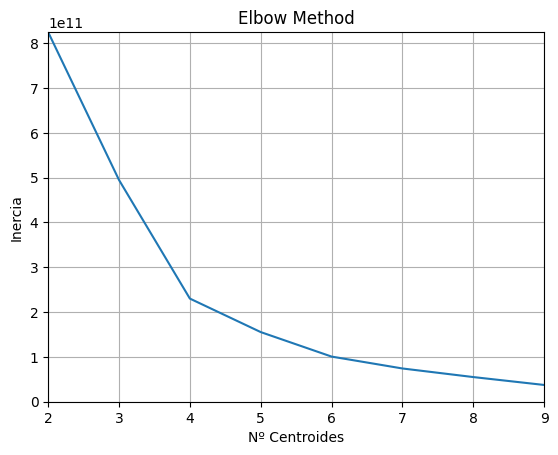

In [14]:
plt.plot(range(2,centroids_max), losses, color='tab:blue')
plt.xlabel('Nº Centroides')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.xlim([2,9])
plt.ylim([0, max(losses)])
plt.grid()

In [15]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, verbose=1, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(municipios_cluster_array)

centroids = kmeans.cluster_centers_
print(f'Silhouette Score: {silhouette_score(municipios_cluster_array, clusters)}')

Initialization complete
Iteration 0, inertia 200724189269.0.
Iteration 1, inertia 158378810946.21072.
Iteration 2, inertia 157924391164.1978.
Iteration 3, inertia 157742356365.09198.
Iteration 4, inertia 157574313263.4839.
Iteration 5, inertia 157445023785.91867.
Iteration 6, inertia 157224141195.6308.
Iteration 7, inertia 157102569388.05103.
Converged at iteration 7: center shift 59789.1512238616 within tolerance 181417.25175580257.
Initialization complete
Iteration 0, inertia 281372319143.0.
Iteration 1, inertia 172738563814.05005.
Iteration 2, inertia 159920145444.557.
Iteration 3, inertia 157888332603.565.
Iteration 4, inertia 157634351478.47046.
Iteration 5, inertia 157451481534.98624.
Iteration 6, inertia 157245820658.89236.
Iteration 7, inertia 157109032157.82254.
Converged at iteration 7: center shift 77844.59578910127 within tolerance 181417.25175580257.
Initialization complete
Iteration 0, inertia 228224019813.0.
Iteration 1, inertia 164338521448.4378.
Iteration 2, inertia 15

In [16]:
merged_municipios_df['cluster'] = clusters.astype(str)
merged_municipios_df

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,MORT1,...,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT,cluster
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,0.125025,...,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089,0
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,0.343893,...,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132,0
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,-0.604534,...,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989,0
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,1.492948,...,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011,0
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,-0.203276,...,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,0.672194,...,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504,0
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,1.821250,...,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355,0
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,-0.221515,...,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089,0
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,0.508044,...,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100,3


In [17]:
fig = px.scatter_mapbox(
    merged_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    size='POP_TOT',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [18]:
# Identifica clusters mais populosos
mean_pop = []
for i in range(n_clusters):
    mask = merged_municipios_df['cluster'].isin([str(i)])
    _len = merged_municipios_df[mask]['POP_TOT'].shape[0]
    _val = sum(merged_municipios_df[mask]['POP_TOT'].values)
    # Lista contendo médias de população de cada cluster
    mean_pop.append(_val / _len)

# Cria uma lista contendo os clusters mais populosos
_temp = mean_pop.copy()
_temp.sort()
highest_clusters = [str(mean_pop.index(_temp[-1])), str(mean_pop.index(_temp[-2])), str(mean_pop.index(_temp[-3]))]
highest_clusters
print(f'Clusters com maior população: {highest_clusters}')

# Remove clusters selecionados
mask = merged_municipios_df['cluster'].isin(highest_clusters)
lowPop_municipios_df = merged_municipios_df[~mask]
lowPop_municipios_df

Clusters com maior população: ['2', '1', '4']


,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,MORT1,...,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT,cluster
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,0.125025,...,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089,0
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,0.343893,...,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132,0
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,-0.604534,...,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989,0
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,1.492948,...,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011,0
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,-0.203276,...,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,0.672194,...,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504,0
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,1.821250,...,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355,0
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,-0.221515,...,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089,0
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,0.508044,...,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100,3


In [19]:
fig = px.scatter_mapbox(
    lowPop_municipios_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Por caracteristicas

Após a clusterização por população, realizou-se um agrupamento com base em indicadores socioeconômicos, a fim de identificar cidades com caracteristicas semelhantes àquelas ajudadas pela ONG.


### Análise de correlação

Por se tratar de um longo conjunto de dados com variáveis diversas, foi preciso avaliar a existência de variáveis correlacionadas a fim de melhorar os posteriores procedimentos de otimização. Para isso, realizou-se um algoritmo que identifica exclui variáveis redundantes com base em uma tolerância positiva e negativa.

In [20]:
# Plot de matrix de correlação
def plot_correlation(correlation_matrix):
    # Gera uma máscara com o triângulo superior
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.xlabel("Features")
    plt.ylabel("Features")
    plt.title("Matriz de Correlação entre Features em cada Cluster")

    plt.show()

In [21]:
# Função para remoção de features correlacionadas a partir de uma tolerância
def remove_correlated(data, tolerance = 0.85):

    features = data.columns
    n_features = features.shape[0]
    correlation_matrix = data.corr().values
    correlated_features = []
    remove_features = []

    # Gera uma lista de variáveis correlacionadas 
    for row in range(n_features):
        for col in range(row, n_features):
            if(row == col):
                pass
            else:
                _val = correlation_matrix[row][col]
                if(_val >= tolerance or _val <= -tolerance):
                    correlated_features.append([features[row], features[col]])
                    # Apenas o primeiro feature do par é selecionado para remoção (pode ser alterado depois)
                    if(features[row] not in remove_features):
                        remove_features.append(features[row])

    # Remove features selecionadas
    for feature in remove_features:
        data.drop([feature], axis=1, inplace=True)

    print(f'Initial number of features: {n_features}')
    print(f'Final number of features: {data.shape[1]}')
    print('Features removed: \n', remove_features, '\n')

    return remove_features

Initial number of features: 71
Final number of features: 31
Features removed: 
 ['MORT1', 'MORT5', 'SOBRE40', 'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29', 'GINI', 'PIND', 'PINDCRI', 'PMPOB', 'PMPOBCRI', 'PPOB', 'PPOBCRI', 'PREN10RICOS', 'PREN20', 'PREN20RICOS', 'PREN40', 'PREN60', 'PREN80', 'RDPC', 'RDPC1', 'RDPC10', 'RDPC2', 'RDPC3', 'RDPC4', 'RDPC5', 'RDPCT', 'RMPOB', 'REN1', 'REN2', 'REN3', 'REN5', 'RENOCUP', 'PEA', 'PEA1014', 'PEA1517', 'IDHM'] 



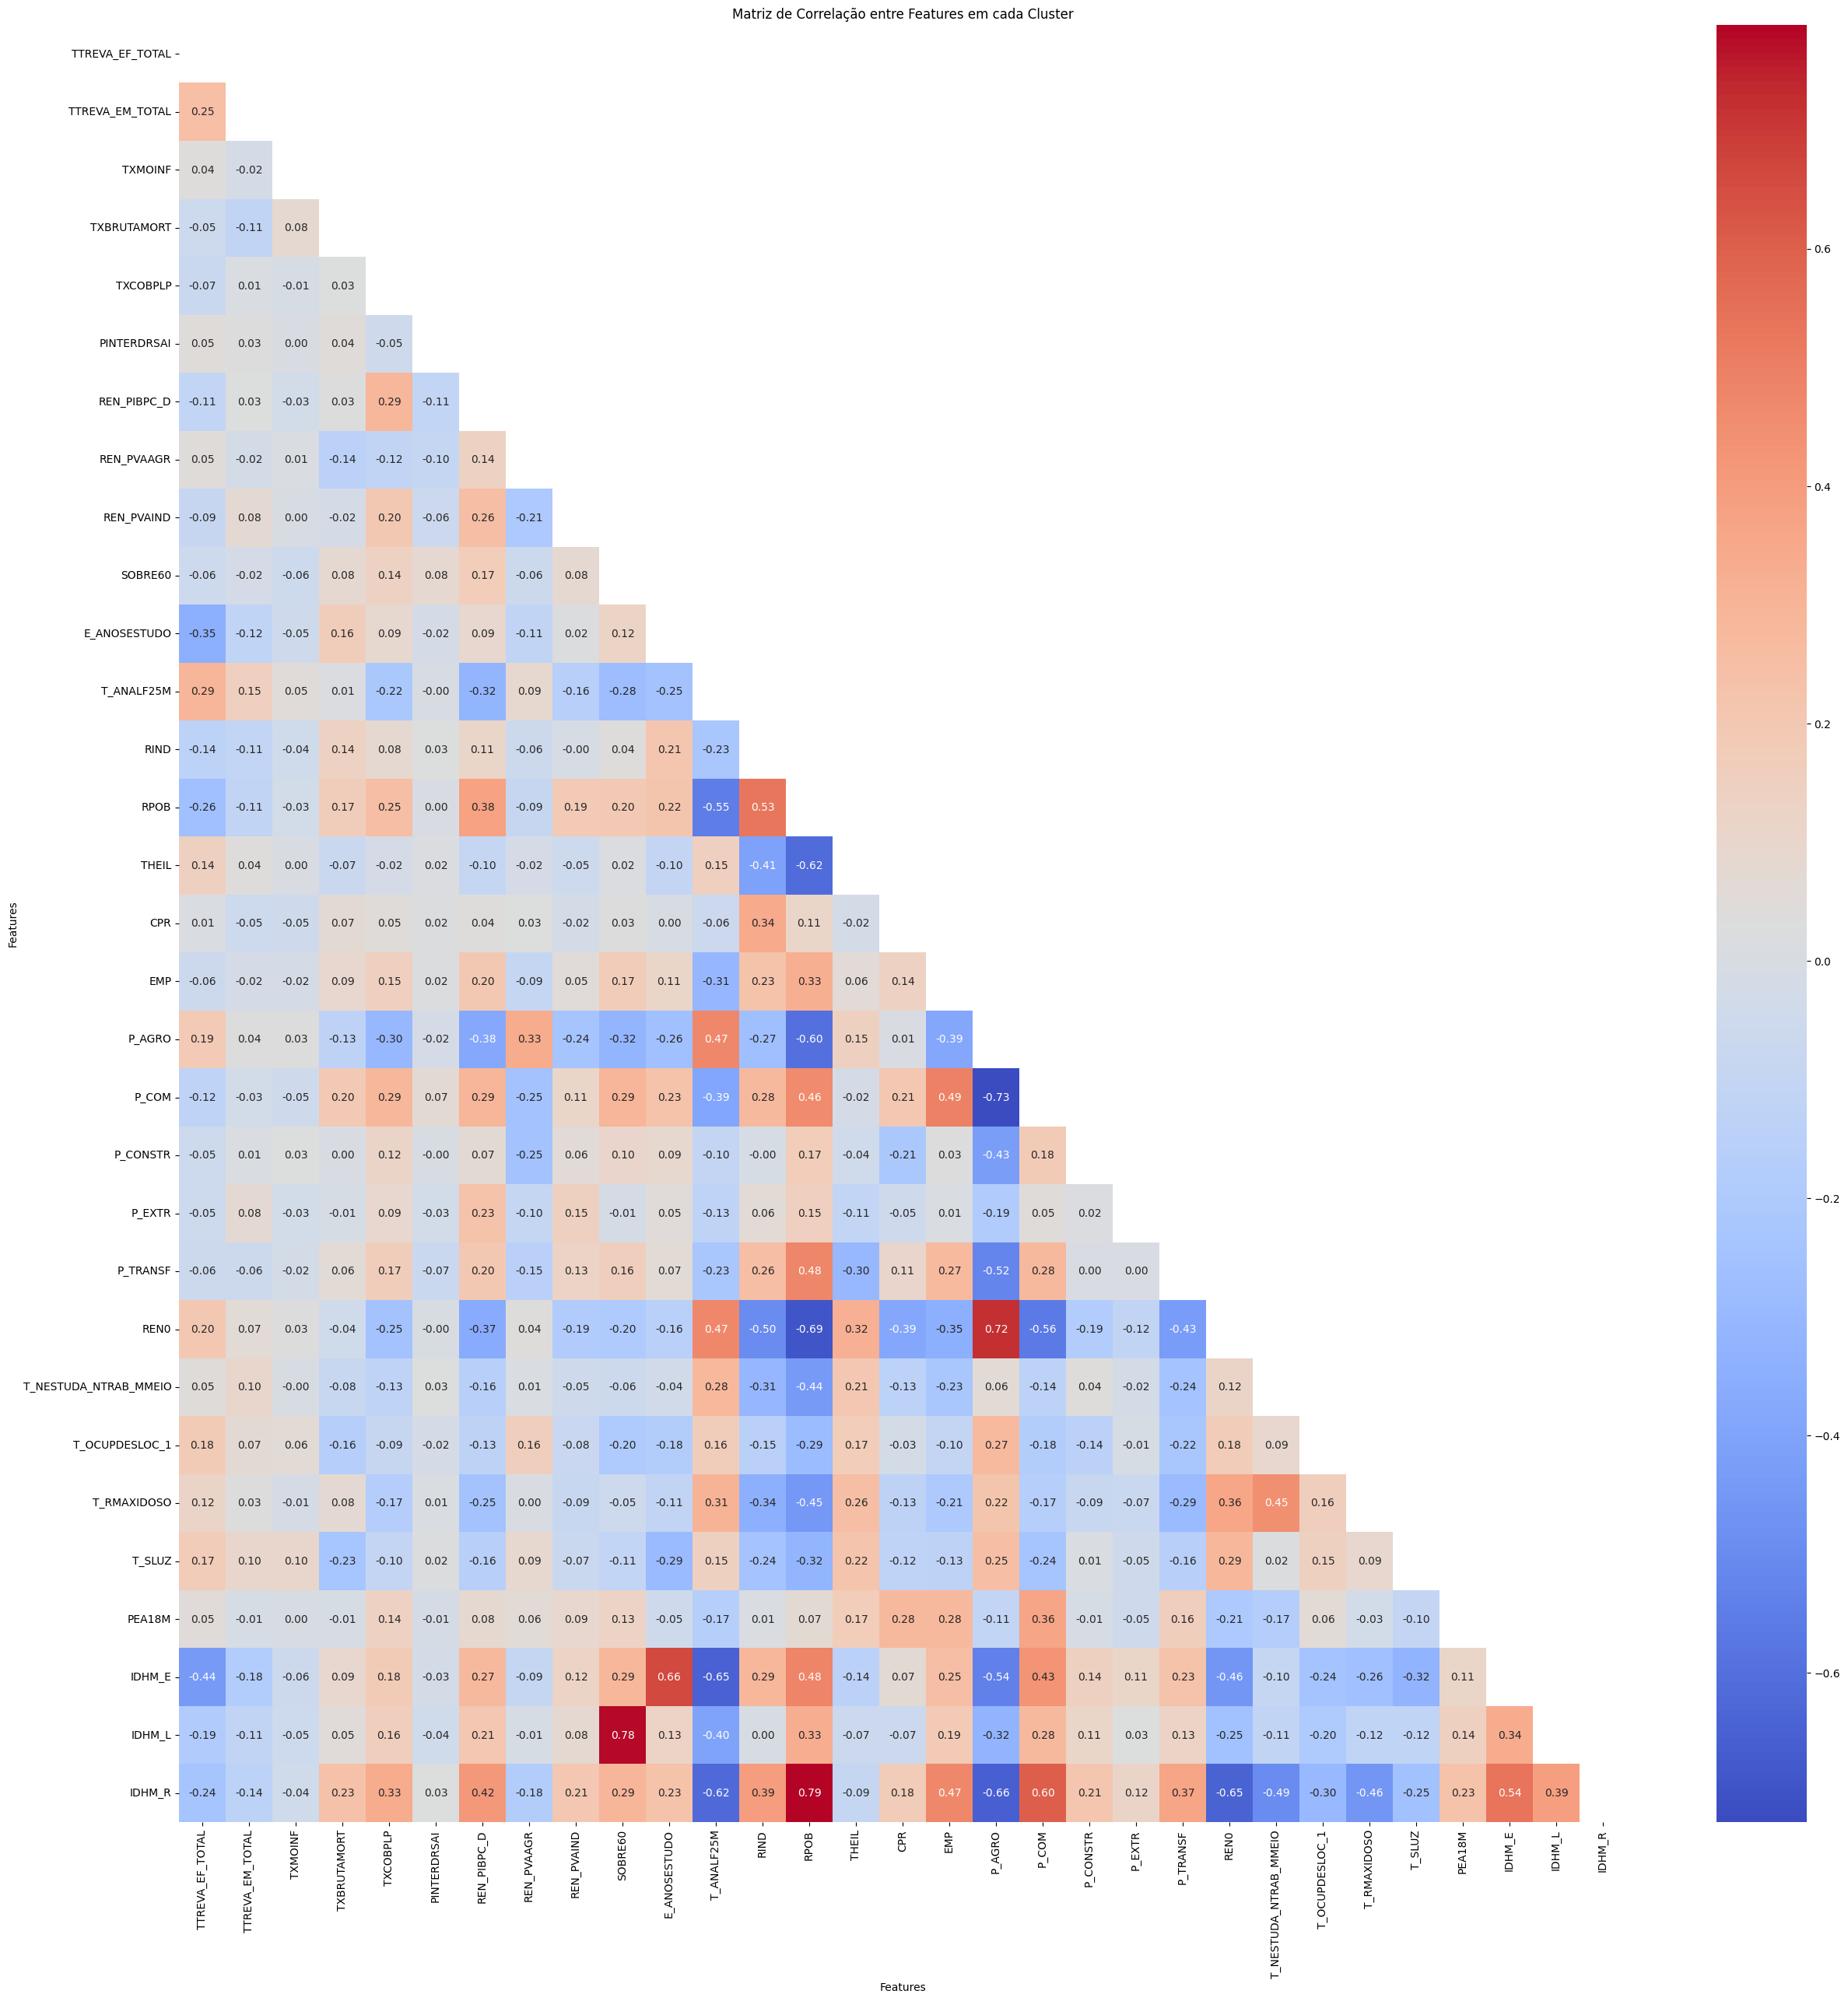

In [22]:
data = lowPop_municipios_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
).copy()

remove_features = remove_correlated(data, tolerance=0.8)

plot_correlation(data.corr())

In [23]:
# Remove as features redundantes
reduced_lowPop_df = lowPop_municipios_df.copy()
for feature in remove_features:
    reduced_lowPop_df.drop([feature], axis=1, inplace=True)
reduced_lowPop_df

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,SOBRE60,...,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT,cluster
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,-0.117474,...,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089,0
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,-0.188764,...,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132,0
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,0.822872,...,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989,0
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,-1.516112,...,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011,0
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,0.232185,...,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,-0.518055,...,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504,0
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,-1.550060,...,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355,0
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,0.418897,...,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089,0
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,-0.358501,...,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100,3


In [24]:
a = reduced_lowPop_df.drop(columns=[
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],).values.reshape(-1,1)

# Determinação do número de centroides pelo método do cotovelo
centroids_max = 10
clusters_list = []
losses = []
for i in range(2,centroids_max):
    kmeans = KMeans(n_clusters=i, init='k-means++', verbose=0, max_iter=30)
    # kproto = KPrototypes(n_clusters=i, verbose=0, max_iter=30)
    clusters = kmeans.fit_predict(a)
    losses.append(kmeans.inertia_)
print('Otimização finalizada!')

Otimização finalizada!


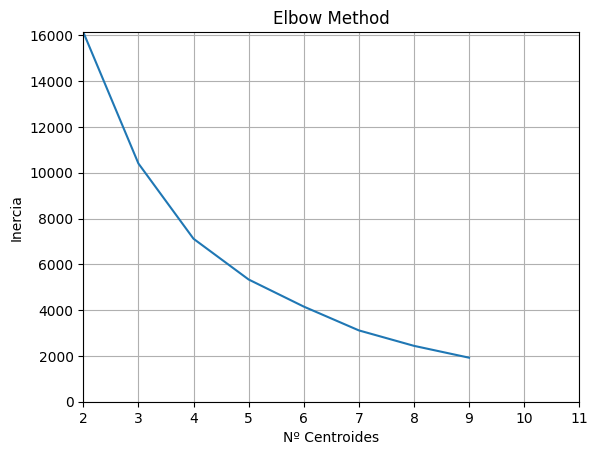

In [25]:
plt.plot(range(2,centroids_max), losses, color='tab:blue')
plt.xlabel('Nº Centroides')
plt.ylabel('Inercia')
plt.title('Elbow Method')
plt.xlim([2,11])
plt.ylim([0, max(losses)])
plt.grid()

### Otimização de features : Análise por score

Foi implementado um algorítmo para avaliar as melhores features na clusterização de um determinado modelo. Nele, utilizamos o score do silhouette para determinar o quanto uma variável influencia positivamente a formação dos clusters.

Silhouette score é uma métrica usada para calcular a qualidade de uma técnica de agrupamento (clustering). Seu valor varia de -1 a 1.

- 1: Significa que os clusters estão bem separados uns dos outros e claramente distintos. 

- 0: Significa que os clusters são indiferentes, ou podemos dizer que a distância entre os clusters não é significativa. 

- -1: significa que os clusters foram atribuídos de maneira errada.

O algorítmo apresenta a seguinte lógica:

1. Executar clusterização em cada um das variáveis individualmente para algum k.
2. Para cada cluster, é medido uma métrica de desempenho, como o coeficiente de silhueta implementado aqui.
3. A variável que oferece o melhor desempenho é salva numa lista.
4. O passo 2 e 3 são repetidos, porém, cada iteração as variáveis já escolhidas e salvas na lista são treinadas juntamente com as novas candidatas em busca de uma melhor performance. 
5. O critério de parada pode ser um número de variáveis desejada ou um ponto em que a métrica de desempenho não melhore significativamente. (ainda não implementado)

In [26]:
# Função auxiliar para escolha de melhor variável
def find_best_feature(cluster_model, data_df, features_selected):
    # Setar variaveis de melhor candidato e score
    best_feature_candidate = None
    best_score = -1
    
    data_array = data_df.values

    for feature_candidate in data_df.columns:
        # Verifique se a variável já foi selecionada.
        if feature_candidate not in features_selected:
            # Copia as variáveis selecionadas até agora e adiciona nova característica candidata.
            selected_features = features_selected + [feature_candidate]
            # Transformar o DataFrame em uma matriz numpy para treinar modelo
            current_data = data_df[selected_features].values

            # Executar o modelo de cluster
            clusters = cluster_model.fit_predict(current_data)
            # Calcular o índice de melhor desempenho.
            score = silhouette_score(current_data, clusters)

            # Se o valor do score for melhor do que o melhor até agora, atualize
            if score > best_score:
                best_score = score
                best_feature_candidate = feature_candidate

    return best_score, best_feature_candidate

# Plot das pontuações
def plot_scores(performance_scores):
    # Plota a curva de desempenho
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(performance_scores) + 1), performance_scores, marker='o', linestyle='-', color='b')
    plt.xlabel('Número de características')
    plt.ylabel('Pontuação de desempenho')
    plt.title('Curva de desempenho em relação ao número de características')
    plt.grid(True)
    plt.show()

# Função acha os melhores features de um dataset para se realizar um cluster
def cluster_feature_optimizer(cluster_model, data_df, desired_num_features=5):
    features_selected = []    # Lista com índices dos melhores features
    remaining_features = data_df.columns.tolist()    # Lista com nomes das colunas que não foram selecionadas
    performance_scores = []  # Lista dos resultados do desempenho

    while len(features_selected) < desired_num_features and remaining_features:
        best_score, best_feature_candidate = find_best_feature(cluster_model, data_df, features_selected)

        features_selected.append(best_feature_candidate)        # Salvar a melhor variável ao array
        remaining_features.remove(best_feature_candidate)       # Remove variável para
        performance_scores.append(best_score)                   # Armazena o resultado do desempenho
        print(best_feature_candidate)

    plot_scores(performance_scores)

    return features_selected

Algoritmos implementados deste artigo: https://www.public.asu.edu/~huanliu/papers/pakdd00clu.pdf

In [27]:
import numpy as np

# Função para calcular a entropia de uma feature
def calculate_entropy(data, feature_index):
    feature_values = data[:, feature_index]
    unique_values, counts = np.unique(feature_values, return_counts=True)
    total_count = len(feature_values)
    probabilities = counts / total_count
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Função para classificar características com base na entropia
def rank_features(data):
    num_features = data.shape[1]
    feature_entropies = []

    for feature_index in range(num_features):
        entropy = calculate_entropy(data, feature_index)
        feature_entropies.append(entropy)

    # Classificação de características com base na entropia (ordem crescente)
    ranked_features = np.argsort(feature_entropies)

    return ranked_features




In [38]:
# Função para calcular a classificação de características para uma amostra
def rank_sample(data_sample):
    num_features = data_sample.shape[1]
    return np.random.permutation(num_features)

# Função SRANK
def srank(data, num_samples=10):
    num_data_points, num_features = data.shape
    overall_rank = np.zeros(num_features)

    for _ in range(num_samples):
        # Amostragem aleatória de dados
        sample_indices = np.random.choice(num_data_points, size=int(0.7 * num_data_points), replace=False)
        data_sample = data[sample_indices]

        # Classificação de características para a amostra
        feature_rankings = rank_sample(data_sample)

        # Atualização da classificação geral
        overall_rank += feature_rankings

    # Normalização das classificações gerais
    overall_rank /= num_samples

    # Classificação final de características
    final_ranking = np.argsort(overall_rank)

    return final_ranking


In [29]:
# Preparação do dataframe para a otimização
data = reduced_lowPop_df.drop(['codigo_ibge', 'nome', 'codigo_uf', 'UF', 'latitude', 'longitude', 'POP_TOT', 'cluster'], axis=1, inplace=False)
data

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,SOBRE60,...,P_TRANSF,REN0,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,T_RMAXIDOSO,T_SLUZ,PEA18M,IDHM_E,IDHM_L,IDHM_R
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,-0.117474,...,-0.423020,-1.425392,1.470296,-0.163516,1.215415,-0.510555,-0.000023,1.958863,-0.320630,-0.586800
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,-0.188764,...,-0.689499,0.929531,-1.331112,1.614676,-0.276170,-0.271893,-0.000028,0.341660,-0.388975,0.385212
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,0.822872,...,-0.507809,0.176124,0.507606,0.144704,1.614650,0.708479,-0.000006,-0.451087,0.636197,-0.770695
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,-1.516112,...,3.383827,-1.415335,1.225385,-0.448027,-0.253990,-0.520558,-0.000010,1.166117,-1.653354,-0.087659
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,0.232185,...,0.056296,-0.055179,0.989893,-0.574476,-0.026648,0.029650,0.000011,0.452645,0.021094,-0.219012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,-0.518055,...,-0.457628,-0.108814,-0.639709,0.927108,-0.974830,-0.048951,-0.000025,-0.149843,-0.696527,0.280130
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,-1.550060,...,-0.493966,1.003280,0.969170,-1.301559,0.622108,-0.143273,-0.000084,-0.720621,-1.687526,-1.296107
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,0.418897,...,-0.526843,0.156010,0.696000,0.041964,-0.980375,1.435897,-0.000014,0.151401,0.226128,0.175047
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,-0.358501,...,-0.336501,-0.184238,-0.788539,1.077267,0.161879,0.092531,0.000010,-0.149843,-0.559837,0.017424


In [48]:
ranked_features = rank_features(data.values)
selected_columns = data.iloc[:, ranked_features[:15]]

# Exiba a classificação das características
print("Classificação de características com base na entropia:", selected_columns.columns)

Classificação de características com base na entropia: Index(['P_EXTR', 'THEIL', 'TTREVA_EF_TOTAL', 'IDHM_L', 'EMP', 'IDHM_R',
       'TTREVA_EM_TOTAL', 'IDHM_E', 'E_ANOSESTUDO', 'TXMOINF', 'TXCOBPLP',
       'T_OCUPDESLOC_1', 'REN_PIBPC_D', 'TXBRUTAMORT', 'T_SLUZ'],
      dtype='object')


In [49]:
data_array = data.values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score: {silhouette_score(data_array, clusters)}')

Silhouette Score: 0.06381777442269303


In [50]:
data_array = selected_columns.values

kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score: {silhouette_score(data, clusters)}')

Silhouette Score: 0.06861843966593656


In [51]:
ranked_features = srank(data.values)
selected_columns = data.iloc[:, ranked_features[:15]]
# Exiba a classificação das características
print("Classificação de características com base na entropia:", selected_columns.columns)

Classificação de características com base na entropia: Index(['P_EXTR', 'E_ANOSESTUDO', 'EMP', 'RPOB', 'RIND', 'CPR', 'TXCOBPLP',
       'T_OCUPDESLOC_1', 'IDHM_R', 'PINTERDRSAI', 'TTREVA_EM_TOTAL',
       'P_CONSTR', 'PEA18M', 'T_ANALF25M', 'THEIL'],
      dtype='object')


In [52]:
data_array = data.values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score: {silhouette_score(data, clusters)}')

Silhouette Score: 0.08961079263278561


P_EXTR
PEA18M
REN_PVAIND


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 
TXCOBPLP
REN_PIBPC_D
P_TRANSF
T_SLUZ
TTREVA_EM_TOTAL
P_CONSTR
P_COM
T_ANALF25M
P_AGRO
TXBRUTAMORT
IDHM_E
IDHM_L


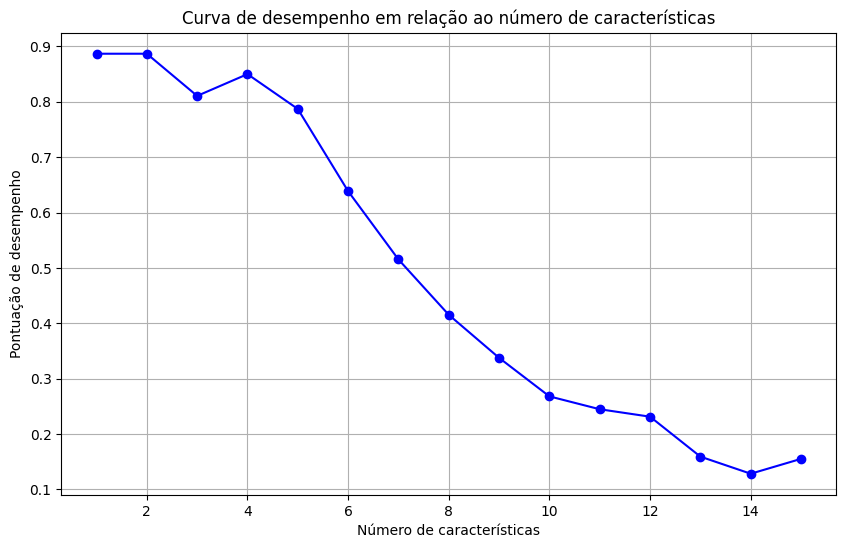

Number of selected features: {len(features_selected)}


In [53]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
features_selected = cluster_feature_optimizer(kmeans, data, 15)
print('Number of selected features: {len(features_selected)}')

In [54]:
n_clusters = 4

In [55]:

data_array = data[features_selected].values

# Clusterização
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(data_array)
centroids = kmeans.cluster_centers_

print(f'Silhouette Score: {silhouette_score(data_array, clusters)}')

Silhouette Score: 0.124266867322916


In [56]:
len(data.columns)

31

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)  # k é o número de componentes desejado

dados_reduzidos = pca.fit_transform(data)

# Ajuste o modelo aos dados reduzidos
kmeans.fit(dados_reduzidos)

# Obtenha os rótulos dos clusters para cada ponto de dados
clusters = kmeans.labels_

print(f'Silhouette Score: {silhouette_score(data, clusters)}')
print(f'Calinski-Harabasz score: {calinski_harabasz_score(data, clusters)}')

Silhouette Score: 0.060416264242537786
Calinski-Harabasz score: 112.91057910171452


In [58]:
_columns = [
    "codigo_ibge",
    "nome",
    "codigo_uf",
    "UF",
    "latitude",
    "longitude",
    "POP_TOT",
]
_columns.extend(features_selected)

reduced2_lowPop_df = reduced_lowPop_df[_columns]
reduced2_lowPop_df['cluster'] = clusters.astype(str)
# Dataframe apenas com variáveis selecionadas pela otimização
reduced2_lowPop_df

/tmp/ipykernel_1619/4078135403.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT,P_EXTR,PEA18M,REN_PVAIND,...,T_SLUZ,TTREVA_EM_TOTAL,P_CONSTR,P_COM,T_ANALF25M,P_AGRO,TXBRUTAMORT,IDHM_E,IDHM_L,cluster
0,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089,-0.320239,-0.000023,-0.223827,...,-0.510555,-1.283042,1.531520,1.383378,0.376130,-0.807821,-0.377189,1.958863,-0.320630,2
1,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132,-0.268427,-0.000028,-0.203934,...,-0.271893,1.029077,-1.187354,-0.185769,-1.572511,0.573377,-0.134548,0.341660,-0.388975,1
2,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989,-0.320239,-0.000006,-0.166138,...,0.708479,-0.061545,-0.704306,-0.231186,-0.161472,0.853734,-1.410144,-0.451087,0.636197,0
3,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011,2.569735,-0.000010,0.864804,...,-0.520558,0.920015,0.299746,-0.723957,-0.976503,-1.646050,-0.411852,1.166117,-1.653354,3
4,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137,-0.320239,0.000011,0.621615,...,0.029650,-0.323295,-0.511086,0.138960,0.323033,0.337736,-0.453447,0.452645,0.021094,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504,-0.320239,-0.000025,-0.130828,...,-0.048951,-0.759544,-0.704306,-0.287957,-0.894203,0.437813,0.371531,-0.149843,-0.696527,1
1258,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355,-0.216614,-0.000084,-0.294446,...,-0.143273,1.465326,0.192785,-1.075937,1.224346,1.168868,-0.980323,-0.720621,-1.687526,0
1259,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089,-0.320239,-0.000014,-0.210897,...,1.435897,-1.173980,-0.669802,-0.390145,-0.379167,0.070865,-0.716885,0.151401,0.226128,0
1260,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100,-0.182073,0.000010,-0.227805,...,0.092531,-0.017920,0.254891,0.366044,-0.795975,-0.362799,-0.370256,-0.149843,-0.559837,1


In [59]:
fig = px.scatter_mapbox(
    reduced2_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Otimização de features: Análise por classificador

Esta abordagem consiste em convertemos o problema de agrupamento não supervisionado em um problema de classificação supervisionado usando um classificador, como modelos baseados em árvore. As etapas para fazer isso são as seguintes:

- 1: Alterar os rótulos do cluster para rótulos binários Um-vs-Todos

- 2: Treinar um classificador para diferencias um cluster cluster dos demais (problema binário)

- 3: Pegar as importâncias de cada variável do modelo (sklearn.ensemble.RandomForestClassifier)

In [60]:
# Essa implementacao está basica. ela apenas analisa a importancia dos features para diferenciação do cluster 1.
# Ja testei com problema de multiclassificacao e os resultados sao parecidos
def features_importance(df_original, clusters):
    df = df_original.copy()
    df["cluster"] = clusters

    print(df['cluster'].value_counts())
    df['cluster'] = df['cluster'].astype(int)
    binary_cluster = df['cluster'].map({0:1, 1:0, 2:0, 3:0})

    # Train a classifier
    
    from sklearn.ensemble import RandomForestClassifier
    df = df.drop(columns=['cluster'])
    clf = RandomForestClassifier(random_state=1)
    clf.fit(df.values, binary_cluster.values)

    # Index sort the most important features
    sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

    # Get the most important features names and weights
    most_important_features = np.take_along_axis(
        np.array(df.iloc[:, 0:len(df.columns)].columns.tolist()), 
        sorted_feature_weight_idxes, axis=0)
    most_important_weights = np.take_along_axis(
        np.array(clf.feature_importances_), 
        sorted_feature_weight_idxes, axis=0)

    return list(zip(most_important_features, most_important_weights))

def features_importance_xgboost(df_original, n_clusters, clusters):
    !pip install xgboost
    import xgboost as xgb

    df = df_original.copy()
    # Treina o modelo xgboost
    clf = xgb.XGBRegressor(objective='multi:softmax', num_class=n_clusters)
    clf.fit(df.values, clusters)
    # Necessário para que apareça os nomes das features
    clf.get_booster().feature_names = df.columns.to_list()
    print("Performance do modelo xgboost: ", str(round(clf.score(df.values, clusters) * 100, 2))+"%")
    feature_importance = clf.get_booster().get_score(importance_type='weight')
    xgb.plot_importance(clf)

    return feature_importance

2    376
1    318
0    302
3    216
Name: cluster, dtype: int64
[('IDHM_E', 0.18766288505073608), ('P_AGRO', 0.14516170033833653), ('T_SLUZ', 0.10600916493634632), ('T_ANALF25M', 0.08755100154568683), ('P_COM', 0.08715662049284098), ('P_TRANSF', 0.06820300496024131), ('REN_PVAIND', 0.05271861731944661), ('REN_PIBPC_D', 0.047126714784709), ('TXBRUTAMORT', 0.040274084640445955), ('TXCOBPLP', 0.038888369308817144), ('IDHM_L', 0.03574058450897585), ('P_CONSTR', 0.03510537998107884), ('TTREVA_EM_TOTAL', 0.028329266825383892), ('PEA18M', 0.02652103909568289), ('P_EXTR', 0.013551566211271703)] 


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Performance do modelo xgboost:  100.0%


{'P_EXTR': 272.0,
 'PEA18M': 372.0,
 'REN_PVAIND': 466.0,
 'TXCOBPLP': 392.0,
 'REN_PIBPC_D': 506.0,
 'P_TRANSF': 475.0,
 'T_SLUZ': 498.0,
 'TTREVA_EM_TOTAL': 336.0,
 'P_CONSTR': 470.0,
 'P_COM': 474.0,
 'T_ANALF25M': 506.0,
 'P_AGRO': 478.0,
 'TXBRUTAMORT': 382.0,
 'IDHM_E': 570.0,
 'IDHM_L': 572.0}

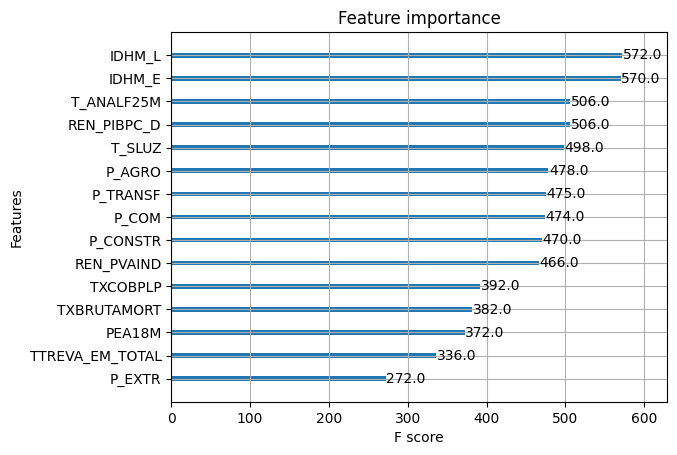

In [61]:
# Análise de todas as variáveis (após a correlação)
df_completo = reduced2_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

clusters = reduced2_lowPop_df['cluster']

important_features = features_importance(df_completo, clusters)
print(important_features, '\n')
features_importance_xgboost(df_completo,  n_clusters=n_clusters, clusters=clusters)

2    619
1    349
0    243
3      1
Name: cluster, dtype: int64
[('IDHM_R', 0.1511410442455627), ('P_AGRO', 0.13547699570880145), ('RPOB', 0.08550518727520734), ('REN0', 0.07578489947814336), ('REN_PIBPC_D', 0.0635915035554362), ('P_COM', 0.05808752796743828), ('REN_PVAIND', 0.05789241404020009), ('TXCOBPLP', 0.05559119385725978), ('T_ANALF25M', 0.04274026061795654), ('P_TRANSF', 0.03225171697911528), ('EMP', 0.025547240149871447), ('REN_PVAAGR', 0.02304756961758893), ('IDHM_E', 0.022572085399290166), ('PEA18M', 0.01835074354709568), ('T_RMAXIDOSO', 0.01506435004146947), ('T_NESTUDA_NTRAB_MMEIO', 0.013682425014972464), ('SOBRE60', 0.012136113244803246), ('P_EXTR', 0.011473490286800152), ('IDHM_L', 0.011325019123727713), ('RIND', 0.01083535400706915), ('THEIL', 0.010297022900978819), ('CPR', 0.008132854403126813), ('T_SLUZ', 0.008112174647708373), ('P_CONSTR', 0.007181725491679696), ('T_OCUPDESLOC_1', 0.00691758680156651), ('E_ANOSESTUDO', 0.006589124819040833), ('TTREVA_EM_TOTAL', 0.00

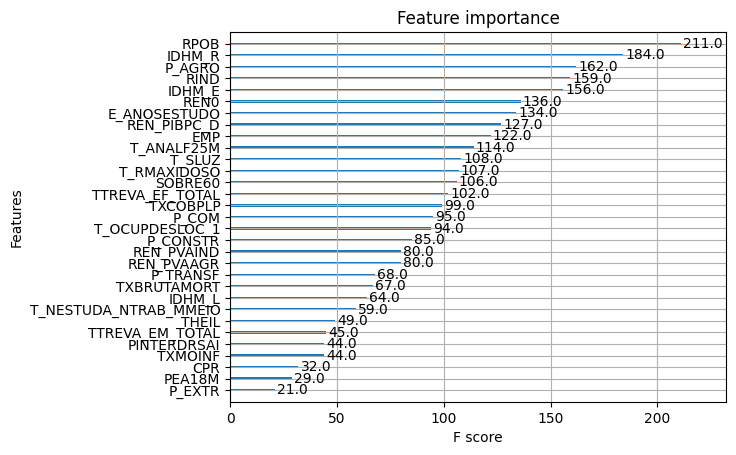

In [62]:
# Análise de variáveis obtidas pela otimização
df_completo = reduced_lowPop_df.drop(
    [
        "codigo_ibge",
        "nome",
        "codigo_uf",
        "UF",
        "latitude",
        "longitude",
        "POP_TOT",
        "cluster",
    ],
    axis=1,
    inplace=False,
)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, verbose=0, init="k-means++", max_iter=100)
clusters = kmeans.fit_predict(df_completo)
reduced_lowPop_df['cluster'] = clusters

important_features = features_importance(df_completo, clusters)
print(important_features, '\n')
feature_importance = features_importance_xgboost(df_completo,  n_clusters=n_clusters, clusters=clusters)

In [63]:
reduced_lowPop_df['cluster'] = reduced_lowPop_df['cluster'].astype(str)
reduced_lowPop_df

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,SOBRE60,...,IDHM_L,IDHM_R,codigo_ibge,nome,codigo_uf,UF,latitude,longitude,POP_TOT,cluster
0,-0.995440,-1.283042,0.078317,-0.377189,-0.132994,0.301449,-0.690576,0.157191,-0.223827,-0.117474,...,-0.320630,-0.586800,2300101,ABAIARA,23,CE,-7.34588,-39.0416,11089,2
1,0.088652,1.029077,3.085875,-0.134548,1.462675,-1.044581,-0.663681,-0.547180,-0.203934,-0.188764,...,-0.388975,0.385212,2900108,ABAÍRA,29,BA,-13.24880,-41.6619,9132,2
2,-0.399189,-0.061545,-0.733222,-1.410144,0.104442,0.779234,-0.640147,-0.666622,-0.166138,0.822872,...,0.636197,-0.770695,2900207,ABARÉ,29,BA,-8.72073,-39.1162,18989,1
3,0.034447,0.920015,0.340458,-0.411852,0.040615,-0.655368,-0.176204,-0.808389,0.864804,-1.516112,...,-1.653354,-0.087659,2300150,ACARAPE,23,CE,-4.22083,-38.7055,16011,0
4,-0.616008,-0.323295,0.103432,-0.453447,-0.184055,0.070665,0.217139,0.754399,0.621615,0.232185,...,0.021094,-0.219012,2300200,ACARAÚ,23,CE,-2.88769,-40.1183,60137,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257,0.305470,-0.759544,-0.666509,0.371531,-0.406172,0.131792,-0.589719,-0.358529,-0.130828,-0.518055,...,-0.696527,0.280130,2933406,WAGNER,29,BA,-12.28190,-41.1715,9504,2
1258,-1.103849,1.465326,-1.274770,-0.980323,-0.413832,-0.695287,-0.579633,0.171702,-0.294446,-1.550060,...,-1.687526,-1.296107,2211704,WALL FERRAZ,22,PI,-7.23151,-41.9050,4355,1
1259,0.251265,-1.173980,0.404031,-0.716885,-0.337239,0.927684,0.200329,2.930022,-0.210897,0.418897,...,0.226128,0.175047,2933455,WANDERLEY,29,BA,-12.11440,-43.8958,13089,1
1260,1.010129,-0.017920,0.064974,-0.370256,-0.230010,1.227079,-0.344300,0.284446,-0.227805,-0.358501,...,-0.559837,0.017424,2933604,XIQUE-XIQUE,29,BA,-10.82300,-42.7245,48100,2


In [64]:
fig = px.scatter_mapbox(
    reduced_lowPop_df,
    lat='latitude',
    lon='longitude',
    hover_name='nome',
    color='cluster',  # Coluna 'cluster' determinar cores
    color_continuous_scale='Viridis',  # Escala de cores
    mapbox_style='stamen-toner',
    center=dict(lat=-12.83, lon=-36.49),
    zoom=4.5
)

fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

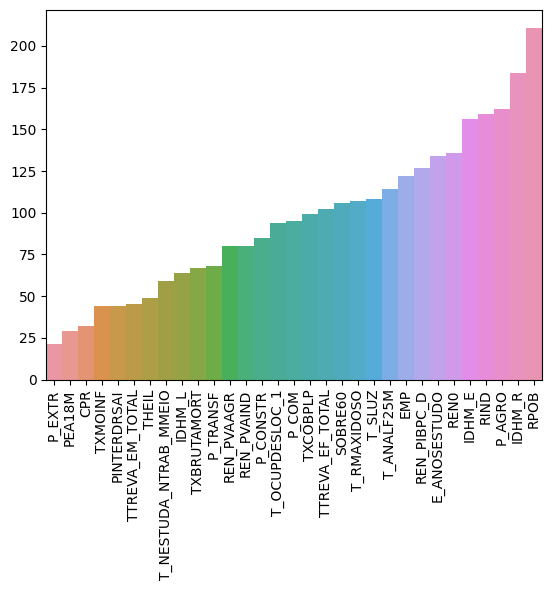

In [65]:
feature_importance_sorted = dict(sorted(feature_importance.items(), key=lambda item: item[1]))
keys = list(feature_importance_sorted.keys())
values = list(feature_importance_sorted.values())

plot = sns.barplot(x=keys, y=values, width=1)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### PCA

Utilizar a Análise de Componentes Principais (PCA) em conjunto com o algoritmo K-Means é uma abordagem comum para redução de dimensionalidade e identificação de quais características (features) são relevantes para o agrupamento. A PCA ajuda a encontrar as direções principais (componentes principais) nos dados, reduzindo a dimensionalidade enquanto mantém a maior parte da variabilidade. Aqui está um guia passo a passo de como fazer isso:

In [66]:
scaler = StandardScaler()

# Ajuste e transforme seus dados usando o scaler
normalized_data = scaler.fit_transform(reduced_lowPop_df)

# Crie uma instância da classe PCA com o número desejado de componentes
pca = PCA(n_components=4)  # k é o número de componentes desejado

# Ajuste e transforme seus dados para o novo espaço de características
dados_reduzidos = pca.fit_transform(normalized_data)

# Ajuste o modelo aos dados reduzidos
kmeans.fit(dados_reduzidos)

# Obtenha os rótulos dos clusters para cada ponto de dados
clusters = kmeans.labels_

print(f'Silhouette Score: {silhouette_score(reduced_lowPop_df, clusters)}')
print(f'Calinski-Harabasz score: {calinski_harabasz_score(reduced_lowPop_df, clusters)}')


ValueError: could not convert string to float: 'ABAIARA'

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = reduced_lowPop_df
df_0 = df.copy()
array = df.values
scaler = StandardScaler()

df = scaler.fit_transform(df)

pca = PCA(n_components=0.95)  # número de componentes principais desejado
X_pca = pca.fit_transform(df)

In [ ]:

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = df_0.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {int('{}'.format(i+1)): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_1 = pd.DataFrame(sorted(dic.items()))
df_1

,0,1
0,1,IDHM_R
1,2,cluster
2,3,P_EXTR
3,4,T_OCUPDESLOC_1
4,5,TXBRUTAMORT
5,6,P_EXTR
6,7,IDHM_L
7,8,TXCOBPLP
8,9,TXCOBPLP
9,10,T_OCUPDESLOC_1


In [ ]:
loadings_df = pd.DataFrame(pca.components_, columns=df.columns)
loadings_df

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
kmeans = KMeans(n_clusters=3, verbose=0, init='k-means++', max_iter=100)
clusters = kmeans.fit_predict(X_pca)

centroids = kmeans.cluster_centers_
centroids
print(f'Silhouette Score: {silhouette_score(reduced_lowPop_df, clusters)}')

Silhouette Score: -0.05521086455841598


In [ ]:
# fig = px.scatter_mapbox(
#     lowPop_municipios_df,
#     lat='latitude',
#     lon='longitude',
#     hover_name='nome',
#     size='POP_TOT',
#     color='cluster',  # Coluna 'cluster' determinar cores
#     color_continuous_scale='Viridis',  # Escala de cores
#     mapbox_style='stamen-toner',
#     center=dict(lat=-12.83, lon=-36.49),
#     zoom=4.5
# )

# fig.update_layout(height=700, margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()

### Cidades do bem

<img src="cidades do bem.png" width="75%" align="" />

<img src="cidades do bem 2.png" width="75%" align="" />

In [ ]:
municipios_do_bem = [
                    'INAJÁ',
                    'BUÍQUE',
                    'SÃO JOSÉ DA TAPERA',
                    'MAURITI'
                    ]
                    
mask = reduced_lowPop_df['nome'].isin(municipios_do_bem)
municipios_do_bem_df = lowPop_municipios_df[mask]

municipios_do_bem_df[['nome', 'UF', 'cluster']]

,nome,UF,cluster
185,BUÍQUE,PE,2
487,INAJÁ,PE,0
696,MAURITI,CE,2
1069,SÃO JOSÉ DA TAPERA,AL,2


In [ ]:
# Removendo cluster 1
mask = lowPop_municipios_df['cluster'].isin(['1'])
bemLike_municipios_df = lowPop_municipios_df[~mask]
bemLike_municipios_df

,codigo_ibge,nome,latitude,longitude,codigo_uf,UF,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,...,T_SLUZ,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R,cluster
4,2300200,ACARAÚ,-2.88769,-40.1183,23,CE,3.1,10.3,17.56,5.12,...,4.42,22732.0,791.0,1043.0,20898.0,0.601,0.517,0.758,0.554,0
7,2300309,ACOPIARA,-6.08911,-39.4480,23,CE,3.2,13.7,17.30,6.68,...,1.60,20411.0,585.0,771.0,19055.0,0.595,0.517,0.724,0.563,0
8,2400208,AÇU,-5.58362,-36.9140,24,RN,4.0,17.5,14.18,4.84,...,1.35,23246.0,283.0,632.0,22330.0,0.661,0.568,0.795,0.641,0
10,2600104,AFOGADOS DA INGAZEIRA,-7.74312,-37.6310,26,PE,2.7,6.1,12.54,6.79,...,0.22,15536.0,447.0,633.0,14456.0,0.657,0.565,0.807,0.623,0
18,2600500,ÁGUAS BELAS,-9.11125,-37.1226,26,PE,5.1,9.3,21.41,6.83,...,0.77,16124.0,774.0,852.0,14497.0,0.526,0.385,0.691,0.546,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1229,2933000,VALENTE,-11.40620,-39.4570,29,BA,2.7,8.6,10.10,4.42,...,2.04,12942.0,296.0,466.0,12180.0,0.637,0.568,0.729,0.623,0
1234,2314003,VÁRZEA ALEGRE,-6.78264,-39.2942,23,CE,2.0,11.3,17.58,6.38,...,0.29,14459.0,426.0,539.0,13494.0,0.629,0.576,0.759,0.569,0
1236,3170800,VÁRZEA DA PALMA,-17.59440,-44.7226,31,MG,2.0,9.1,29.61,6.10,...,0.87,16452.0,252.0,500.0,15700.0,0.666,0.573,0.814,0.634,0
1251,2314102,VIÇOSA DO CEARÁ,-3.56670,-41.0916,23,CE,3.3,9.1,11.90,5.34,...,1.44,22846.0,1092.0,1513.0,20241.0,0.571,0.475,0.753,0.521,0


# Análise de features do cluster

- Remove highly correlated features: Correlated features can affect the performance of the k-means algorithm, so it is often a good idea to remove them.

- Remove features with low variance: Features that do not vary much can be removed as they do not provide much information.

- Remove features with low relevance: Features that are not relevant to the problem can be removed.

- Remove features with low mutual information: Features that have low mutual information with the target variable can be removed.

- Remove features with low silhouette score: Features that have a low silhouette score can be removed as they do not contribute much to the clustering.

## Silhouette Coefficient

In [ ]:
print(f'Silhouette Score: {silhouette_score(lowPop_cluster_array, clusters)}')

Silhouette Score: 0.6587182297867419


In [ ]:
print(f'Calinski-Harabasz score: {calinski_harabasz_score(lowPop_cluster_array, clusters)}')

Calinski-Harabasz score: 2390.8426116773276


## 

In [ ]:
from sklearn.decomposition import PCA
df = lowPop_municipios_df.drop(['codigo_ibge', 'nome', 'codigo_uf', 'UF', 'latitude', 'longitude', 'POP_TOT', 'cluster'], axis=1)
array = df.values

pca = PCA(n_components=6)  # número de componentes principais desejado
X_pca = pca.fit_transform(df)

In [ ]:
loadings_df = pd.DataFrame(pca.components_, columns=df.columns)
loadings_df

,TTREVA_EF_TOTAL,TTREVA_EM_TOTAL,TXMOINF,TXBRUTAMORT,TXCOBPLP,PINTERDRSAI,REN_PIBPC_D,REN_PVAAGR,REN_PVAIND,MORT1,...,T_RMAXIDOSO,T_SLUZ,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R
0,-0.000003,-0.000012,-0.000023,0.000003,0.000090,-0.000052,0.000071,-0.000084,0.000227,-0.000114,...,-0.000030,-0.000076,0.727237,0.014753,0.027151,0.685330,0.000001,0.000002,6.575190e-07,0.000002
1,-0.000980,-0.000948,-0.001181,0.000627,0.002512,0.000927,0.002536,-0.003894,0.008144,-0.004118,...,-0.001274,-0.002172,-0.222983,-0.248118,-0.195554,0.220667,0.000060,0.000069,2.295940e-05,0.000073
2,-0.000579,0.000537,-0.000772,0.000057,0.000317,-0.000689,0.000191,-0.001493,-0.000299,-0.000973,...,0.000717,-0.000157,-0.409792,-0.462644,-0.423266,0.475968,0.000005,0.000030,3.813403e-06,-0.000024
3,-0.003021,-0.000049,-0.000162,0.000189,0.006283,-0.005296,0.009206,-0.003463,0.044055,-0.014245,...,-0.007506,-0.017029,0.057691,-0.179279,0.307250,-0.070264,0.000133,0.000161,6.977178e-05,0.000137
4,0.000728,0.002579,-0.008284,-0.001116,-0.004353,-0.010750,-0.004064,0.013135,-0.033758,0.001034,...,0.002560,0.007946,-0.006603,-0.661531,0.658518,-0.003877,-0.000044,-0.000042,-1.287263e-05,-0.000064
5,0.003650,0.012165,0.007339,-0.007167,0.003372,-0.011868,0.005678,0.008039,0.036743,0.002197,...,0.006467,0.010329,0.005796,0.054673,-0.043117,-0.006259,-0.000090,-0.000095,-1.130231e-05,-0.000135


In [ ]:
kmeans = KMeans(n_clusters=6)  # Escolha o número de clusters desejado
clusters = kmeans.fit(X_pca)
labels = kmeans.labels_

In [ ]:
print(f'Silhouette Score: {silhouette_score(X_pca, labels)}')

Silhouette Score: 0.5559429199813808


# QEdu

In [ ]:
QEdu_2019 = pd.read_csv("./Data/QEdu_2019.csv", sep = ';')

In [ ]:
QEdu_2019

,COD Municipio,Cidade,COD UF,UF,Total de escolas federais,Total de escolas estaduais,Total de escolas municipais,Total de escolas privadas,Total de escolas sem creche,Total de escolas com creche,...,Total de docentes em Ensino Fundamental - Projovem Urbano,Total de docentes em Nível Médio,Total de docentes em Curso FIC Concomitante,Total de docentes em Ensino Fundamental - Anos Iniciais,Total de docentes em Ensino Fundamental - Anos Finais,Total de docentes em Ensino Médio,Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental),Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio),Total de docentes em Nao aplicável para turmas de atendimento educacional especializado (AEE) e atividade complementar,Unnamed: 76
0,2100477,Alto Alegre do Pindaré,21.0,MA,NaN,"8,0","55,0","1,0",20.0,"44,0",...,NaN,NaN,NaN,"11,0","20,0","10,0",NaN,NaN,NaN,"4,2"
1,2611804,Ribeirão,26.0,PE,NaN,"3,0","32,0","16,0",10.0,"41,0",...,NaN,NaN,NaN,"40,0","42,0","24,0",NaN,NaN,NaN,"4,1"
2,2914000,Ipirá,29.0,BA,NaN,"4,0","56,0","9,0",55.0,"14,0",...,NaN,NaN,NaN,"4,0","42,0","21,0",NaN,"14,0",NaN,"3,5"
3,2905800,Camamu,29.0,BA,NaN,"1,0","81,0","4,0",61.0,"25,0",...,NaN,NaN,NaN,"13,0","17,0","20,0",NaN,"7,0",NaN,"3,5999999999999996"
4,2101707,Barreirinhas,21.0,MA,"1,0","5,0","140,0","5,0",148.0,"3,0",...,NaN,NaN,NaN,"8,0","16,0","37,0",NaN,NaN,NaN,"3,8000000000000003"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,2200400,Altos,22.0,PI,NaN,"8,0","54,0","5,0",49.0,"18,0",...,NaN,NaN,NaN,"40,0","55,0","56,0",NaN,NaN,NaN,"4,2"
1791,2604007,Carpina,26.0,PE,NaN,"9,0","22,0","36,0",23.0,"44,0",...,NaN,"12,0","1,0","16,0","55,0","29,0",NaN,NaN,NaN,"4,5"
1792,2931905,Tucano,29.0,BA,NaN,"4,0","56,0","7,0",20.0,"47,0",...,NaN,NaN,NaN,"8,0","29,0","18,0",NaN,"10,0",NaN,"3,8"
1793,2930204,Sento Sé,29.0,BA,NaN,"2,0","62,0","3,0",61.0,"6,0",...,NaN,NaN,NaN,"7,0","62,0","3,0",NaN,"4,0",NaN,"3,4"


In [ ]:
QEdu_2019.columns

Index(['COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
       'Total de escolas estaduais', 'Total de escolas municipais',
       'Total de escolas privadas', 'Total de escolas sem creche',
       'Total de escolas com creche',
       'Escolas que não funcionam em prédio escolar',
       'Escolas que funcionam em prédio escolar',
       'Total de escolas que não funcionam em unidade de atendimento socio educativo',
       'Total de escolas que funcionam em unidade de atendimento socio educativo',
       'Total de escolas que não funcionam em unidade prisional',
       'Total de escolas que funcionam em unidade prisional',
       'Total de escolas que não funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
       'Total de escolas que não funcionam em salas de outra escola',
       'Total de escolas que funcionam em salas de outra escola',
       'Total de escolas que não funcionam em ou

In [ ]:
colunas_para_manter = [
                        'COD Municipio', 'Cidade', 'COD UF', 'UF', 'Total de escolas federais',
                        'Total de escolas estaduais', 'Total de escolas municipais',
                        'Total de escolas privadas', 'Total de escolas sem creche',
                        'Total de escolas com creche',
                        'Escolas que funcionam em prédio escolar',
                        'Total de escolas que funcionam em unidade de atendimento socio educativo',
                        'Total de escolas que funcionam em unidade prisional',
                        'Total de escolas que funcionam em galpão / rancho / paiol / barracão',
                        'Total de escolas que funcionam em salas de outra escola',
                        'Total de escolas que funcionam em outros locais',
                        'Total de escolas que não tem abastecimento de água da rede pública',
                        'Total de escolas que não possuem abastecimento de água',
                        'Total de escolas que não possuem energia elétrica da rede pública',
                        'Total de escolas que não possuem energia elétrica', 
                        'Total de matrículas', 'Total de docentes',
                        'Total de docentes em Ensino Fundamental - Anos Iniciais',
                        'Total de docentes em Ensino Fundamental - Anos Finais',
                        'Total de docentes em Ensino Médio',
                        'Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental)',
                        'Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio)',
                        'Total de docentes em Nao aplicável para turmas de atendimento educacional especializado (AEE) e atividade complementar',
                        ]



In [ ]:
# QEdu_2019.rename(columns={'COD Municipio': 'codigo_ibge'})

In [ ]:
codigos_ibge = merged_municipios_df.codigo_ibge

# Converter a coluna para numérica (int64) e tratar erros como NaN
QEdu_2019['COD Municipio'] = pd.to_numeric(QEdu_2019['COD Municipio'], errors='coerce')

# Remover as linhas onde a coluna não pôde ser convertida para numérica (NaN)
QEdu_2019 = QEdu_2019.dropna(subset=['COD Municipio'])

# Pegar apenas linhas com os mesmos codigos municipais que temos nos datasets anteriores
QEdu_2019['COD Municipio'] = QEdu_2019['COD Municipio'].astype('int64')
mascara = QEdu_2019['COD Municipio'].isin(codigos_ibge)
QEdu_2019_filtrado = QEdu_2019[mascara] 

QEdu_2019_filtrado = QEdu_2019_filtrado[colunas_para_manter]

# Função para trocar as vírgulas por pontos para que os dados sejam numéricos
def remover_virgulas_e_converter(valor):
    if isinstance(valor, str):
        try:
            return float(valor.replace(',', '.'))
        except ValueError:
            return valor  # Retorna o valor original em caso de erro
    else:
        return valor  # Retorna o valor original se não for uma string

# Aplicar a função às colunas selecionadas
colunas_total = [col for col in QEdu_2019_filtrado.columns if col.startswith("Total")]
QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(remover_virgulas_e_converter)


# QEdu_2019_filtrado[colunas_total] = QEdu_2019_filtrado[colunas_total].applymap(converter_colunas_para_numeros)

# Considerar falores nulos como 0
QEdu_2019_filtrado = QEdu_2019_filtrado.fillna(0)


QEdu_2019_filtrado

/tmp/ipykernel_37/965503913.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,COD Municipio,Cidade,COD UF,UF,Total de escolas federais,Total de escolas estaduais,Total de escolas municipais,Total de escolas privadas,Total de escolas sem creche,Total de escolas com creche,...,Total de escolas que não possuem energia elétrica da rede pública,Total de escolas que não possuem energia elétrica,Total de matrículas,Total de docentes,Total de docentes em Ensino Fundamental - Anos Iniciais,Total de docentes em Ensino Fundamental - Anos Finais,Total de docentes em Ensino Médio,Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental),Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio),Total de docentes em Nao aplicável para turmas de atendimento educacional especializado (AEE) e atividade complementar
2,2914000,Ipirá,29.0,BA,0.0,4.0,56.0,9.0,55.0,14.0,...,0.0,0.0,14672.0,618.0,4.0,42.0,21.0,0.0,14.0,0.0
5,2611101,Petrolina,26.0,PE,2.0,50.0,121.0,158.0,161.0,170.0,...,0.0,0.0,110379.0,3983.0,42.0,375.0,287.0,7.0,40.0,0.0
6,2602803,Buíque,26.0,PE,0.0,10.0,38.0,3.0,47.0,4.0,...,1.0,0.0,16275.0,505.0,15.0,55.0,43.0,0.0,0.0,0.0
9,2917508,Jacobina,29.0,BA,1.0,5.0,49.0,30.0,51.0,34.0,...,0.0,0.0,20927.0,996.0,14.0,54.0,34.0,4.0,17.0,0.0
10,2112209,Timon,21.0,MA,1.0,13.0,156.0,23.0,161.0,32.0,...,0.0,0.0,47723.0,2157.0,72.0,128.0,136.0,0.0,23.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,2303501,Cascavel,23.0,CE,0.0,5.0,54.0,8.0,19.0,48.0,...,0.0,0.0,19493.0,706.0,9.0,24.0,37.0,0.0,0.0,0.0
1789,2909208,Coronel João Sá,29.0,BA,0.0,1.0,66.0,0.0,62.0,5.0,...,7.0,3.0,7735.0,498.0,204.0,14.0,0.0,0.0,0.0,0.0
1790,2200400,Altos,22.0,PI,0.0,8.0,54.0,5.0,49.0,18.0,...,0.0,0.0,12738.0,610.0,40.0,55.0,56.0,0.0,0.0,0.0
1792,2931905,Tucano,29.0,BA,0.0,4.0,56.0,7.0,20.0,47.0,...,0.0,0.0,13752.0,754.0,8.0,29.0,18.0,0.0,10.0,0.0


In [ ]:
# Agrupe o DataFrame por UF e calcule a soma das colunas
QEdu_2019_somas = QEdu_2019_filtrado.groupby('UF').sum()

# Reset o índice para tornar a coluna 'UF' novamente uma coluna do DataFrame
QEdu_2019_somas = QEdu_2019_somas.reset_index()

QEdu_2019_somas.drop(columns=['COD Municipio', 'COD UF'], inplace=True)

# Soma da coluna 'Quantidade de municípios' em cada grupo
somas_por_estado = QEdu_2019_filtrado.groupby('UF').size().reset_index(name='Quantidade de municípios')
QEdu_2019_somas = QEdu_2019_somas.merge(somas_por_estado, on='UF', how='left')

QEdu_2019_somas.drop(3, inplace=True)

QEdu_2019_somas

,UF,Total de escolas federais,Total de escolas estaduais,Total de escolas municipais,Total de escolas privadas,Total de escolas sem creche,Total de escolas com creche,Escolas que funcionam em prédio escolar,Total de escolas que funcionam em unidade de atendimento socio educativo,Total de escolas que funcionam em unidade prisional,...,Total de escolas que não possuem energia elétrica,Total de matrículas,Total de docentes,Total de docentes em Ensino Fundamental - Anos Iniciais,Total de docentes em Ensino Fundamental - Anos Finais,Total de docentes em Ensino Médio,Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental),Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio),Total de docentes em Nao aplicável para turmas de atendimento educacional especializado (AEE) e atividade complementar,Quantidade de municípios
0,AL,5.0,105.0,821.0,120.0,588.0,463.0,1043.0,0.0,1.0,...,0.0,295077.0,12618.0,1246.0,909.0,678.0,16.0,31.0,0.0,38
1,BA,19.0,599.0,8077.0,1071.0,6626.0,3140.0,9583.0,0.0,4.0,...,203.0,1940241.0,90687.0,2674.0,5571.0,3340.0,54.0,882.0,0.0,278
2,CE,29.0,512.0,4546.0,707.0,2192.0,3602.0,5756.0,1.0,5.0,...,0.0,1718347.0,71515.0,1796.0,2947.0,1682.0,36.0,58.0,0.0,175
4,PB,18.0,431.0,2453.0,510.0,2251.0,1161.0,3383.0,6.0,27.0,...,5.0,653036.0,32823.0,1893.0,2467.0,2673.0,55.0,106.0,0.0,182
5,PE,12.0,560.0,3094.0,719.0,2662.0,1723.0,4330.0,1.0,7.0,...,17.0,1101927.0,43398.0,1361.0,3792.0,2390.0,60.0,113.0,0.0,123
6,PI,22.0,560.0,2638.0,423.0,1990.0,1653.0,3613.0,0.0,2.0,...,27.0,820811.0,39608.0,2788.0,3595.0,3636.0,51.0,439.0,0.0,176
7,RN,14.0,380.0,1606.0,289.0,1156.0,1133.0,2249.0,0.0,3.0,...,4.0,485431.0,21279.0,564.0,1563.0,729.0,0.0,79.0,0.0,140
8,SE,3.0,86.0,413.0,79.0,374.0,207.0,576.0,0.0,1.0,...,0.0,129105.0,5968.0,194.0,504.0,157.0,0.0,0.0,0.0,29


In [ ]:
# Calcular a razão entre o 'Total de escolas federais' e 'Quantidade de municípios' e criar uma nova coluna
QEdu_2019_somas['Escolas federais por Município'] = QEdu_2019_somas['Total de escolas federais'] / QEdu_2019_somas['Quantidade de municípios']

QEdu_2019_somas['Escolas estaduais por Município'] = QEdu_2019_somas['Total de escolas estaduais'] / QEdu_2019_somas['Quantidade de municípios']

QEdu_2019_somas['Escolas municipais por Município'] = QEdu_2019_somas['Total de escolas municipais'] / QEdu_2019_somas['Quantidade de municípios']

QEdu_2019_somas['Escolas privadas por Município'] = QEdu_2019_somas['Total de escolas privadas'] / QEdu_2019_somas['Quantidade de municípios']

QEdu_2019_somas['Total de escolas'] = QEdu_2019_somas['Total de escolas federais'] + QEdu_2019_somas['Total de escolas estaduais'] + QEdu_2019_somas['Total de escolas municipais'] + QEdu_2019_somas['Total de escolas privadas']

In [ ]:
QEdu_2019_somas

,UF,Total de escolas federais,Total de escolas estaduais,Total de escolas municipais,Total de escolas privadas,Total de escolas sem creche,Total de escolas com creche,Escolas que funcionam em prédio escolar,Total de escolas que funcionam em unidade de atendimento socio educativo,Total de escolas que funcionam em unidade prisional,...,Total de docentes em Ensino Médio,Total de docentes em Nível Fundamental (EJA integrada à Educação Profissional de Nível Fundamental),Total de docentes em Curso Técnico Integrado na Modalidade EJA (EJA integrada à Educação Profissional de Nível Médio),Total de docentes em Nao aplicável para turmas de atendimento educacional especializado (AEE) e atividade complementar,Quantidade de municípios,Escolas federais por Município,Escolas estaduais por Município,Escolas municipais por Município,Escolas privadas por Município,Total de escolas
0,AL,5.0,105.0,821.0,120.0,588.0,463.0,1043.0,0.0,1.0,...,678.0,16.0,31.0,0.0,38,0.131579,2.763158,21.605263,3.157895,1051.0
1,BA,19.0,599.0,8077.0,1071.0,6626.0,3140.0,9583.0,0.0,4.0,...,3340.0,54.0,882.0,0.0,278,0.068345,2.154676,29.053957,3.852518,9766.0
2,CE,29.0,512.0,4546.0,707.0,2192.0,3602.0,5756.0,1.0,5.0,...,1682.0,36.0,58.0,0.0,175,0.165714,2.925714,25.977143,4.040000,5794.0
4,PB,18.0,431.0,2453.0,510.0,2251.0,1161.0,3383.0,6.0,27.0,...,2673.0,55.0,106.0,0.0,182,0.098901,2.368132,13.478022,2.802198,3412.0
5,PE,12.0,560.0,3094.0,719.0,2662.0,1723.0,4330.0,1.0,7.0,...,2390.0,60.0,113.0,0.0,123,0.097561,4.552846,25.154472,5.845528,4385.0
6,PI,22.0,560.0,2638.0,423.0,1990.0,1653.0,3613.0,0.0,2.0,...,3636.0,51.0,439.0,0.0,176,0.125000,3.181818,14.988636,2.403409,3643.0
7,RN,14.0,380.0,1606.0,289.0,1156.0,1133.0,2249.0,0.0,3.0,...,729.0,0.0,79.0,0.0,140,0.100000,2.714286,11.471429,2.064286,2289.0
8,SE,3.0,86.0,413.0,79.0,374.0,207.0,576.0,0.0,1.0,...,157.0,0.0,0.0,0.0,29,0.103448,2.965517,14.241379,2.724138,581.0


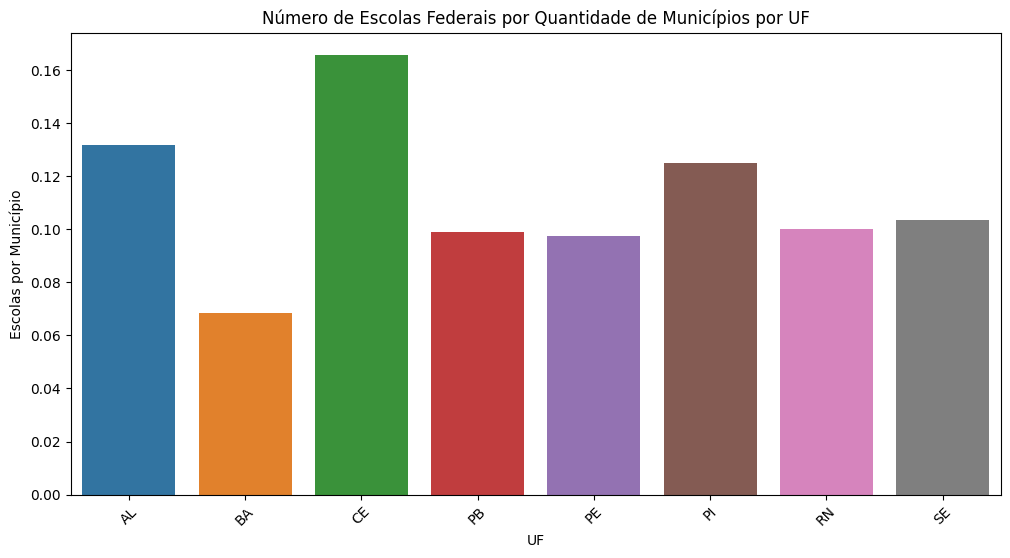

In [ ]:
# Gráfico de Barras para Escolas por Quantidade de Municípios por UF
plt.figure(figsize=(12, 6))
sns.barplot(x='UF', y='Escolas federais por Município', data=QEdu_2019_somas)
plt.xlabel('UF')
plt.ylabel('Escolas por Município')
plt.title('Número de Escolas Federais por Quantidade de Municípios por UF')
plt.xticks(rotation=45)
plt.show()


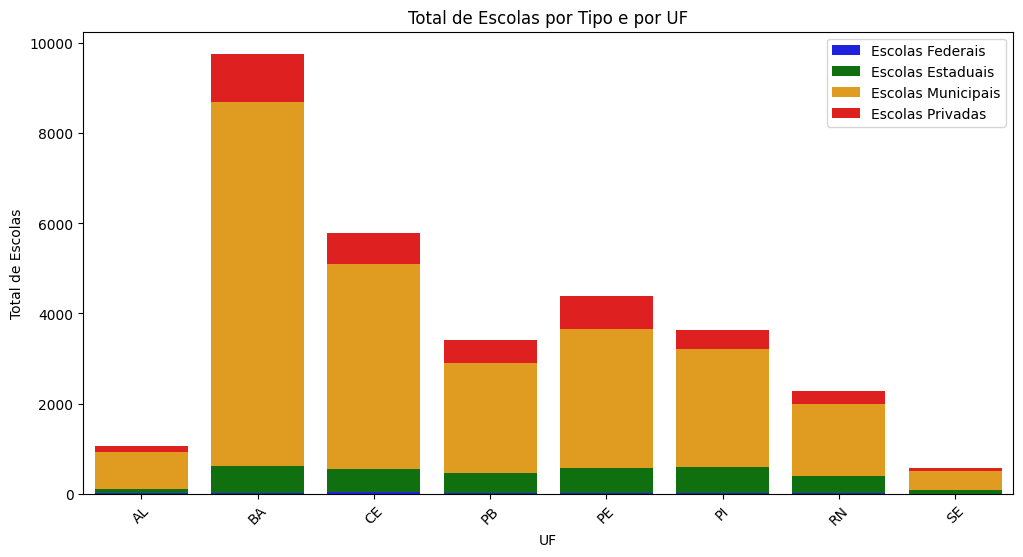

In [ ]:
dados = QEdu_2019_somas[['UF', 'Total de escolas federais', 'Total de escolas estaduais', 'Total de escolas municipais', 'Total de escolas privadas']]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='UF', y='Total de escolas federais', data=dados, label='Escolas Federais', color='blue')
ax = sns.barplot(x='UF', y='Total de escolas estaduais', data=dados, label='Escolas Estaduais', bottom=dados['Total de escolas federais'], color='green')
ax = sns.barplot(x='UF', y='Total de escolas municipais', data=dados, label='Escolas Municipais', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'], color='orange')
ax = sns.barplot(x='UF', y='Total de escolas privadas', data=dados, label='Escolas Privadas', bottom=dados['Total de escolas federais'] + dados['Total de escolas estaduais'] + dados['Total de escolas municipais'], color='red')

plt.xlabel('UF')
plt.ylabel('Total de Escolas')
plt.title('Total de Escolas por Tipo e por UF')
plt.xticks(rotation=45)
plt.legend()

plt.show()

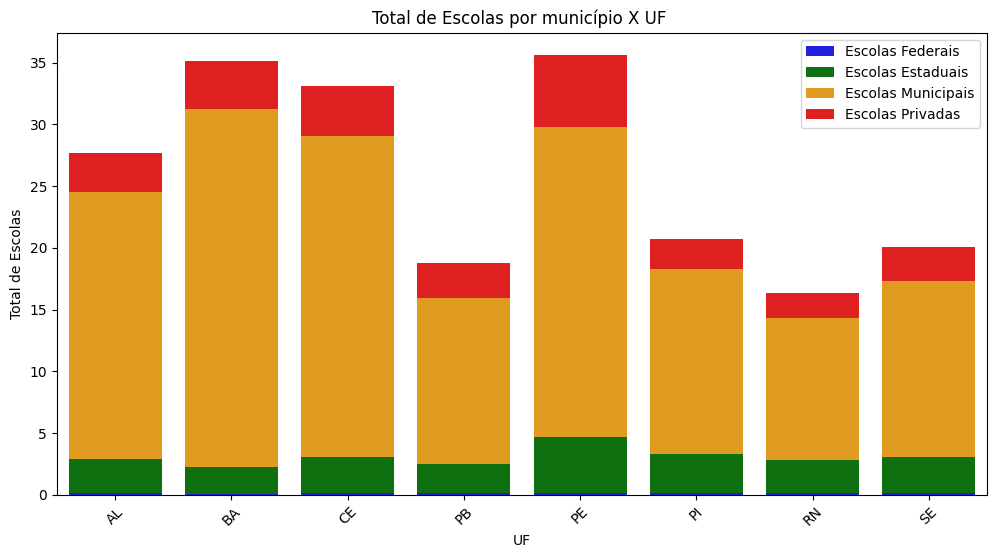

In [ ]:
dados = QEdu_2019_somas[['UF', 'Escolas federais por Município', 'Escolas estaduais por Município', 'Escolas municipais por Município', 'Escolas privadas por Município']]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='UF', y='Escolas federais por Município', data=dados, label='Escolas Federais', color='blue')
ax = sns.barplot(x='UF', y='Escolas estaduais por Município', data=dados, label='Escolas Estaduais', bottom=dados['Escolas federais por Município'], color='green')
ax = sns.barplot(x='UF', y='Escolas municipais por Município', data=dados, label='Escolas Municipais', bottom=dados['Escolas federais por Município'] + dados['Escolas estaduais por Município'], color='orange')
ax = sns.barplot(x='UF', y='Escolas privadas por Município', data=dados, label='Escolas Privadas', bottom=dados['Escolas federais por Município'] + dados['Escolas estaduais por Município'] + dados['Escolas municipais por Município'], color='red')

plt.xlabel('UF')
plt.ylabel('Total de Escolas')
plt.title('Total de Escolas por município X UF ')
plt.xticks(rotation=45)
plt.legend()

plt.show()

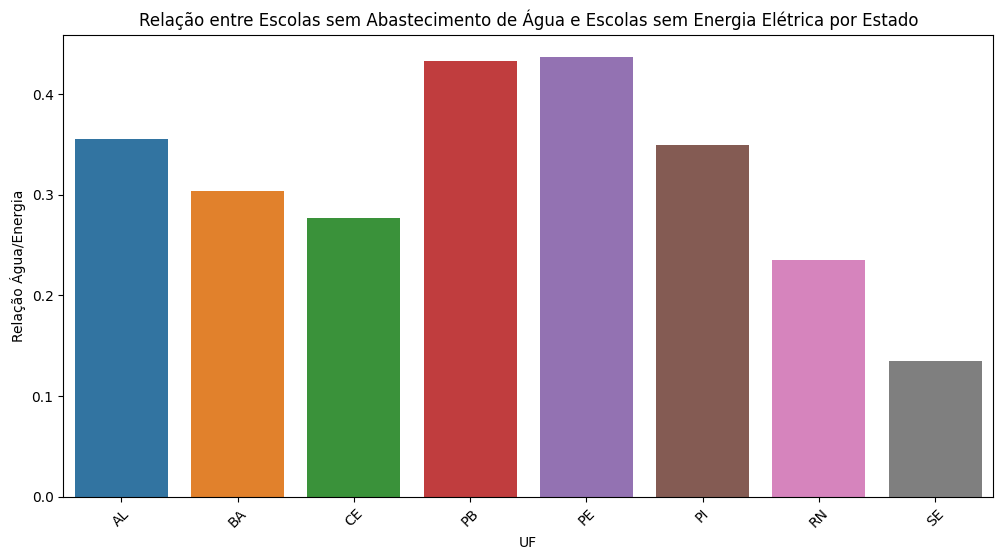

In [ ]:
# Calcule a relação entre escolas sem abastecimento de água e escolas sem energia elétrica
QEdu_2019_somas['Relação Água/Escolas'] = QEdu_2019_somas['Total de escolas que não tem abastecimento de água da rede pública'] / QEdu_2019_somas['Total de escolas']
QEdu_2019_somas['Relação Energia/EscolasEnergia'] = QEdu_2019_somas['Total de escolas que não possuem energia elétrica'] / QEdu_2019_somas['Total de escolas']

# Crie um gráfico de barras para a relação Água/Energia por estado
plt.figure(figsize=(12, 6))
sns.barplot(x='UF', y='Relação Água/Escolas', data=QEdu_2019_somas)
#sns.barplot(x='UF', y='Relação Energia/EscolasEnergia', data=QEdu_2019_somas)
plt.xlabel('UF')
plt.ylabel('Relação Água/Energia')
plt.title('Relação entre Escolas sem Abastecimento de Água e Escolas sem Energia Elétrica por Estado')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Gráfico de Dispersão para Docentes vs. Total de Escolas
plt.figure(figsize=(10, 6))
QEdu_2019_filtrado['Total de docentes em Nível Médio'] = QEdu_2019_filtrado['Total de docentes em Nível Médio']
sns.scatterplot(x='Total de escolas federais', y='Total de docentes em Nível Médio', data=QEdu_2019_filtrado)
plt.xlabel('Total de Escolas Federais')
plt.ylabel('Total de Docentes em Nível Médio')
plt.title('Relação entre Total de Escolas Federais e Total de Docentes em Nível Médio')
plt.show()


KeyError: 'Total de docentes em Nível Médio'

<Figure size 1000x600 with 0 Axes>

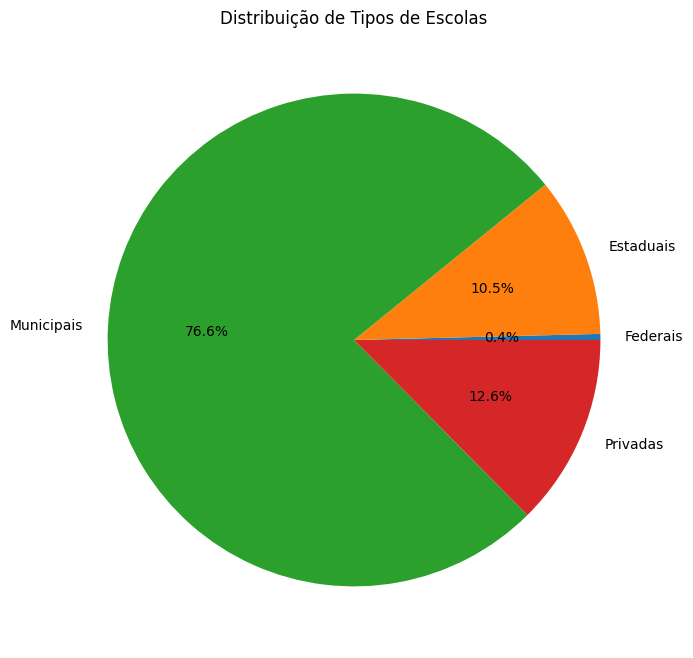

In [ ]:

# Gráfico de Pizza para Tipo de Escolas (Federal, Estadual, Municipal, Privada)
tipo_escolas = ['Total de escolas federais', 'Total de escolas estaduais', 'Total de escolas municipais', 'Total de escolas privadas']
total_tipo_escolas = [QEdu_2019_filtrado[tipo].sum() for tipo in tipo_escolas]
plt.figure(figsize=(8, 8))
plt.pie(total_tipo_escolas, labels=['Federais', 'Estaduais', 'Municipais', 'Privadas'], autopct='%1.1f%%')
plt.title('Distribuição de Tipos de Escolas')
plt.show()



In [ ]:
print(QEdu_2019_filtrado['UF'])

2       BA
5       PE
6       PE
9       BA
10      MA
        ..
1788    CE
1789    BA
1790    PI
1792    BA
1793    BA
Name: UF, Length: 1171, dtype: object


In [ ]:
shape(QEdu_2019_filtrado['UF'])

NameError: name 'shape' is not defined

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 3 with shape (1171,).

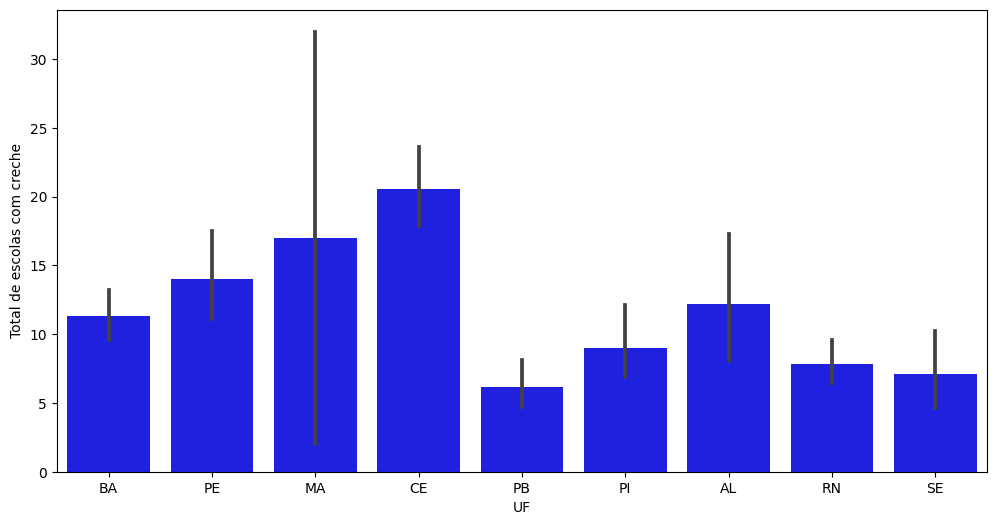

In [ ]:
# Gráfico de Barras Empilhadas para Escolas com/sem Creche por UF

plt.figure(figsize=(12, 6))
sns.barplot(x='UF', y='Total de escolas com creche', data=QEdu_2019_filtrado, label='Com Creche', color='b')
sns.barplot(x='UF', y='Total de escolas sem creche', data=QEdu_2019_filtrado, label='Sem Creche', bottom=QEdu_2019_filtrado['Total de escolas com creche'], color='r')
plt.xlabel('UF')
plt.ylabel('Total de Escolas')
plt.title('Total de Escolas com e Sem Creche por UF')
plt.xticks(rotation=45)
plt.legend()
plt.show()



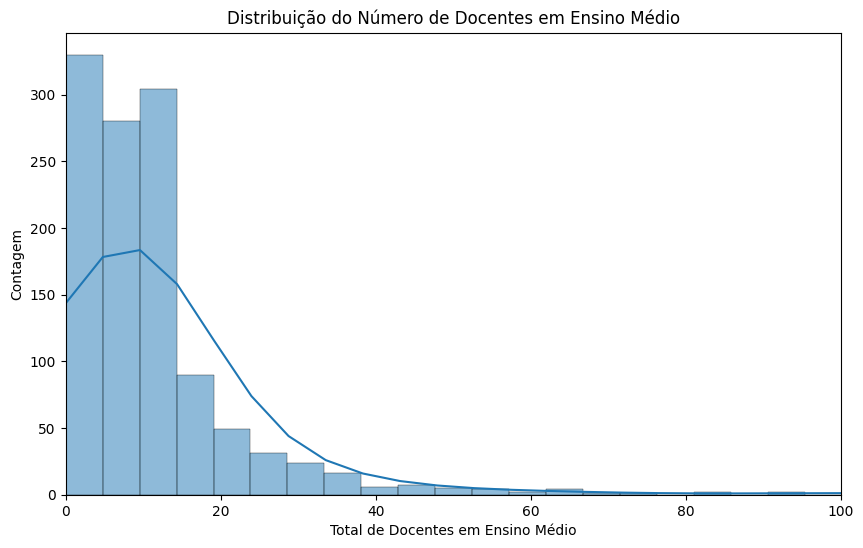

In [ ]:
# Histograma Docentes ensino médio
plt.figure(figsize=(10, 6))
sns.histplot(QEdu_2019_filtrado['Total de docentes em Ensino Médio'], bins=200, kde=True)
plt.xlabel('Total de Docentes em Ensino Médio')
plt.ylabel('Contagem')
plt.title('Distribuição do Número de Docentes em Ensino Médio')

plt.xlim(0,100) 

plt.show()

In [ ]:
# Read Censo Data
censo_df = pd.read_csv("/work/Censo_municipal_estadual_nacional (csv).csv",delimiter=";")

# Filter Relevant Columns
mask_censo = [
"UF",
#"UFN",
"Município",
"MORT1",
"SOBRE40",
"SOBRE60",
"T_ANALF11A14",
"T_ANALF15A17",
"T_ANALF15M",
"T_ANALF18A24",
"T_ANALF18M",
"T_ANALF25A29",
"T_ANALF25M",
"GINI",
"HOMEM65A69",
"HOMEM70A74",
"HOMEM75A79",
"HOMEMTOT",
"HOMENS80",
"MULH0A4",
"MULH10A14",
"MULH15A19",
"MULH20A24",
"MULH25A29",
"MULH30A34",
"MULH35A39",
"MULH40A44",
"MULH5A9",
"MULH60A64",
"MULH65A69",
"MULH70A74",
"MULH75A79",
"MULHER80",
"MULHERTOT",
"PEA",
"PEA1014",
"PEA1517",
"PEA18M",
"IDHM",
"IDHM_E",
"IDHM_L",
"IDHM_R"]

# Filtered dataframe
censo_df = censo_df[mask_censo]
censo_df


,UF,Município,MORT1,SOBRE40,SOBRE60,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,...,MULHER80,MULHERTOT,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R
0,11,ALTA FLORESTA D'OESTE,45.58,83.81,66.87,9.74,8.35,23.55,10.82,25.71,...,25,11146,NaN,NaN,NaN,NaN,0.329,0.112,0.617,0.516
1,11,ARIQUEMES,32.39,88.08,74.23,9.35,7.64,17.18,8.00,18.37,...,47,27318,NaN,NaN,NaN,NaN,0.432,0.199,0.684,0.593
2,11,CABIXI,41.52,85.09,69.00,9.62,6.19,24.57,10.06,27.10,...,8,3584,NaN,NaN,NaN,NaN,0.309,0.108,0.636,0.430
3,11,CACOAL,35.37,87.08,72.44,6.32,6.70,21.41,9.22,23.29,...,94,34032,NaN,NaN,NaN,NaN,0.407,0.171,0.667,0.593
4,11,CEREJEIRAS,43.00,84.62,68.20,5.06,4.83,20.26,8.17,22.29,...,28,9367,NaN,NaN,NaN,NaN,0.386,0.167,0.629,0.547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16690,52,VIANÓPOLIS,14.40,93.03,82.02,0.66,0.74,7.97,1.31,8.52,...,97,6251,6657.0,122.0,334.0,6201.0,0.712,0.622,0.818,0.710
16691,52,VICENTINÓPOLIS,15.70,92.47,80.75,1.22,1.32,12.68,2.40,13.51,...,36,3498,3922.0,84.0,175.0,3663.0,0.684,0.562,0.804,0.707
16692,52,VILA BOA,14.50,93.02,81.98,3.60,1.56,15.88,3.98,17.07,...,12,2147,2008.0,18.0,28.0,1962.0,0.647,0.534,0.818,0.619
16693,52,VILA PROPÍCIO,15.90,92.36,80.50,4.15,1.99,19.25,4.18,20.75,...,23,2456,2200.0,48.0,76.0,2076.0,0.634,0.505,0.802,0.629


In [ ]:
censo_df[mask_censo]

,UF,Município,MORT1,SOBRE40,SOBRE60,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,...,MULHER80,MULHERTOT,PEA,PEA1014,PEA1517,PEA18M,IDHM,IDHM_E,IDHM_L,IDHM_R
0,11,ALTA FLORESTA D'OESTE,45.58,83.81,66.87,9.74,8.35,23.55,10.82,25.71,...,25,11146,NaN,NaN,NaN,NaN,0.329,0.112,0.617,0.516
1,11,ARIQUEMES,32.39,88.08,74.23,9.35,7.64,17.18,8.00,18.37,...,47,27318,NaN,NaN,NaN,NaN,0.432,0.199,0.684,0.593
2,11,CABIXI,41.52,85.09,69.00,9.62,6.19,24.57,10.06,27.10,...,8,3584,NaN,NaN,NaN,NaN,0.309,0.108,0.636,0.430
3,11,CACOAL,35.37,87.08,72.44,6.32,6.70,21.41,9.22,23.29,...,94,34032,NaN,NaN,NaN,NaN,0.407,0.171,0.667,0.593
4,11,CEREJEIRAS,43.00,84.62,68.20,5.06,4.83,20.26,8.17,22.29,...,28,9367,NaN,NaN,NaN,NaN,0.386,0.167,0.629,0.547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16690,52,VIANÓPOLIS,14.40,93.03,82.02,0.66,0.74,7.97,1.31,8.52,...,97,6251,6657.0,122.0,334.0,6201.0,0.712,0.622,0.818,0.710
16691,52,VICENTINÓPOLIS,15.70,92.47,80.75,1.22,1.32,12.68,2.40,13.51,...,36,3498,3922.0,84.0,175.0,3663.0,0.684,0.562,0.804,0.707
16692,52,VILA BOA,14.50,93.02,81.98,3.60,1.56,15.88,3.98,17.07,...,12,2147,2008.0,18.0,28.0,1962.0,0.647,0.534,0.818,0.619
16693,52,VILA PROPÍCIO,15.90,92.36,80.50,4.15,1.99,19.25,4.18,20.75,...,23,2456,2200.0,48.0,76.0,2076.0,0.634,0.505,0.802,0.629


In [ ]:
pip install xlr

ERROR: Could not find a version that satisfies the requirement xlr (from versions: none)
ERROR: No matching distribution found for xlr

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 40.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6e046c8-57b3-47c6-bce9-1538a03fcdec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>